In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import geopandas as gp
import shapely
import fiona
import chart_studio.plotly as py
import plotly.graph_objects as go

shp_file_name = "NSW_LOCALITY_POLYGON_shp/NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = ("https://data.gov.au/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
                 "5e295412-357c-49a2-98d5-6caf099c2339/download/nsw_locality_polygon_shp.zip")

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
import matplotlib.style as style
style.available
style.use('fivethirtyeight')

In [4]:
import plotly.express as px
gapminder = px.data.gapminder()
px.scatter(gapminder, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

# Setting up notebook
> Importing plotting styles and maps data for plotting.


In [5]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [6]:
# unzipping the file
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [7]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.columns
burbs.sample(3)

LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  NSW_LOCALI NSW_LOCA_1  \
1009      13159  2010-11-23      None  NSW2192  2012-02-04       None   
493       19845  2012-11-21      None  NSW3252  2013-01-23       None   
1082      29890  2019-02-26      None  NSW3479  2012-05-04       None   

        NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
1009    KIPPENDUFF       None       None          G       None          1   
493      PITNACREE       None       None          G       None          1   
1082  RUSSELL VALE       None       None          G       None          1   

                                               geometry  
1009  POLYGON ((152.815845209352 -29.1087272930739, ...  
493   POLYGON ((151.598267395374 -32.7205260041827, ...  
1082  POLYGON ((150.88697214798 -34.35154273498, 150...

In [8]:
saved_style_state = matplotlib.rcParams.copy()

# Importing Airbnb Dataset
> Imported Dataset of listings from 10 July, 2019.
> This dataset reveals information about airbnbs in Sydney including, price, host information and location. 
> It was produced by the Airbnb company and it was collected to show how Airbnb is being used and how it affects the neighbourood. 

In [9]:
air_bnb = pd.read_csv("listings.csv")
# , dtype={'user_id': int}

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.



In [10]:
# how many rows and columns are in the airbnb dataset?
air_bnb.shape

(38080, 106)

In [11]:
# all the names of the columns
air_bnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [12]:
# display all 106 columns 
pd.set_option('display.max_columns', 106)

### Tidying Up Dataset
> Using user-defined functions to tidy up elements in columns. 

In [13]:
def float_str_to_int(str1):
    try:
        a = str(str1)
        a = a.strip( '.00' )
        a = a.strip('$')
        a = ''.join(a.split(','))
        if str1 == "$0.00":
            return 0
    #     a = a.strip(' ')
        return int(a.strip(' '))
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()
        return str1
#     return int(float(a))

In [14]:
def remove(str1):
    a = str(str1)
    a = a.strip( 'NSW' )
    a = a.strip('.0')
    a = a.split('\n')
    if a == "nan":
        return a 
    return a

In [15]:
def simplify_postcodes(row):
    z = row.zipcode
    if type(z) is str:
        if "NSW " in z:
            return z[4:]
        else:
            return z
    elif type(z) is float and not np.isnan(z):
        return str(int(z))
    else:
        return "0000"

air_bnb["simple_postcode"] = air_bnb.apply(simplify_postcodes,axis=1)

In [16]:
def clean_up_simple_postcode(row):
    k = row.simple_postcode
    if type(k) is str:
        if "\n2766" in k:
            return k[:4]
        else:
            return k
    else:
        return k

air_bnb["simple_postcode"] = air_bnb.apply(clean_up_simple_postcode,axis=1)

In [17]:
# def convert_to_integer_for_price(row):
#     x = row.price
#     if type(x) is str:
#         if type(x) is float:
#             new_x = float(x)
#             return new_x 
#         return float(x)
#     return float(x)
# air_bnb["price"] = air_bnb.apply(convert_to_integer_for_price,axis=1)
# air_bnb.sample(5)

In [18]:
def simplify_host_response(row):
    y = row.host_response_rate
    if type(y) is str:
        no_p = y.strip('%')
        return no_p
    elif type(y) is float and not np.isnan(y):
        no_p = y.strip('%')
        return str(int(no_p))
    else:
        return "0"

air_bnb["simple_host_response_rate"] = air_bnb.apply(simplify_host_response,axis=1)

In [19]:
air_bnb.head()

id                         listing_url       scrape_id last_scraped  \
0  11156  https://www.airbnb.com/rooms/11156  20190710033517   2019-07-11   
1  12351  https://www.airbnb.com/rooms/12351  20190710033517   2019-07-11   
2  14250  https://www.airbnb.com/rooms/14250  20190710033517   2019-07-10   
3  15253  https://www.airbnb.com/rooms/15253  20190710033517   2019-07-10   
4  20865  https://www.airbnb.com/rooms/20865  20190710033517   2019-07-11   

                                                name  \
0                               An Oasis in the City   
1                  Sydney City & Harbour at the door   
2                                Manly Harbour House   
3  Stunning Penthouse Apartment In Heart Of The City   
4                 3 BED HOUSE + 1 BED STUDIO Balmain   

                                             summary  \
0  Very central to the city which can be reached ...   
1  Come stay with Vinh & Stuart (Awarded as one o...   
2  Beautifully renovated, spacious and quiet, our...   
3  Penthouse living in a great central location: ...   
4  Hi! We are a married professional couple with ...   

                                               space  \
0  Potts Pt. is a vibrant  and popular inner-city...   
1  We're pretty relaxed hosts, and we fully appre...   
2  Our home is a thirty minute walk along the sea...   
3  A charming two-level, two-bedroom, two-bathroo...   
4  HOUSE : _________ * DUCTED AIR CONDITIONING IN...   

                                         description experiences_offered  \
0  Very central to the city which can be reached ...                none   
1  Come stay with Vinh & Stuart (Awarded as one o...                none   
2  Beautifully renovated, spacious and quiet, our...                none   
3  Penthouse living in a great central location: ...                none   
4  Hi! We are a married professional couple with ...                none   

                               neighborhood_overview  \
0  It is very close to everything and everywhere,...   
1  Pyrmont is an inner-city village of Sydney, on...   
2  Balgowlah Heights is one of the most prestigio...   
3  The location is really central and there is nu...   
4  BALMAIN is an older inner city village / subur...   

                                               notes  \
0  $150.00 key security deposit, refundable on re...   
1  We've a few reasons for the 6.00pm arrival tim...   
2                                                NaN   
3  The apartment is on the top floor with 4 fligh...   
4  During your stay guests may use the landline f...   

                                             transit  \
0  It is 7 minutes walk to the Kings Cross.train ...   
1  Our home is centrally located and an easy walk...   
2  Balgowlah - Manly bus # 131 or #132  (Bus stop...   
3  If walking is not your thing I am well service...   
4  Balmain is well serviced by buses (from Darlin...   

                                              access  \
0   Kitchen & laundry facilities.   Shared bathroom.   
1  We look forward to welcoming you just as we wo...   
2  Guests have access to whole house except locke...   
3  Guests have own key and access to use faciliti...   
4  Whole house (including studio/flat & courtyard...   

                                         interaction  \
0                              As much as they want.   
1  As much or as little as you like. We live here...   
2                                                NaN   
3  You would be staying with me and my very cute,...   
4  We will always be available should you require...   

                                         house_rules  thumbnail_url  \
0        Be considerate.   No showering after 2330h.            NaN   
1  We look forward to welcoming you to stay you j...            NaN   
2  Standard Terms and Conditions of Temporary Hol...            NaN   
3  I am fairly easygoing and will try to accomoda...            NaN   
4  PLEASE ENJOY YOURSELVES WITHOUT 

## Which suburb has the worst response rate?
>Which suburb in NSW has 0% response rate?

Text(0.5, 0, 'Percentage %')

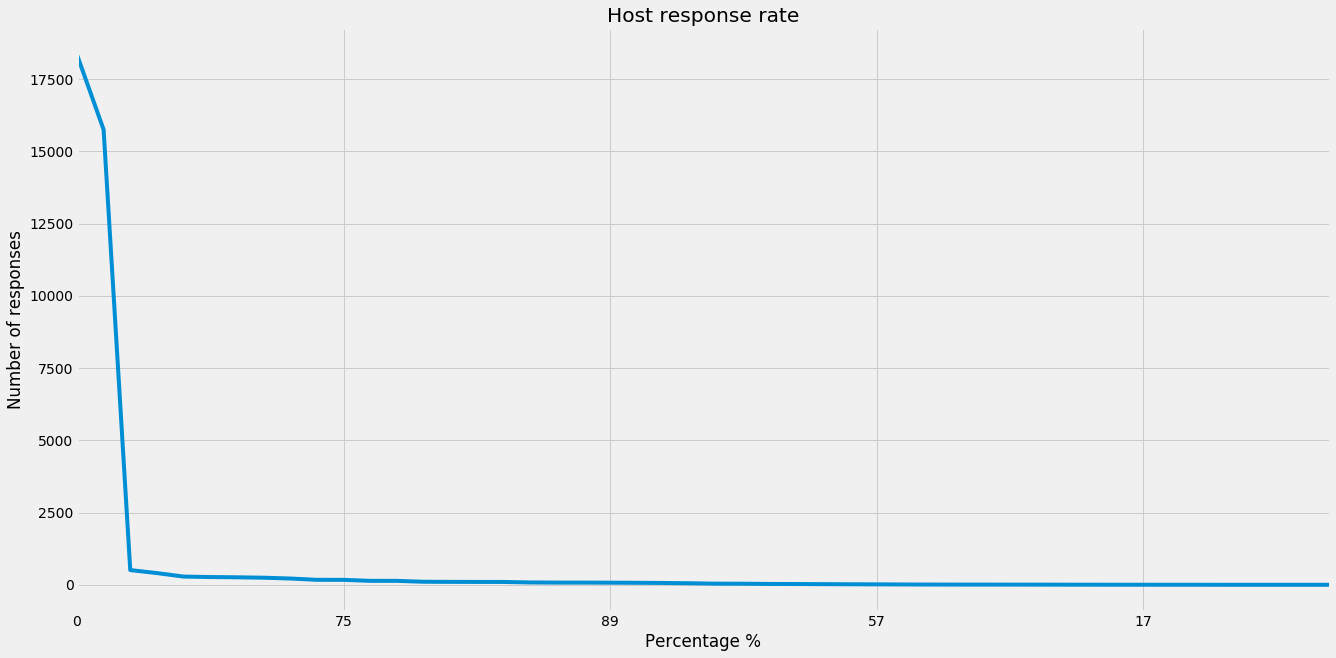

In [20]:
response_rate = air_bnb.simple_host_response_rate.value_counts().plot()
plt.title('Host response rate')
plt.ylabel('Number of responses')
plt.xlabel('Percentage %')

In [21]:
# which suburb is the worst at responding?
air_bnb.simple_host_response_rate.value_counts()[0]

18345

In [22]:
# which suburb is the worst at responding?
def zero_response_rate(column):
    for x in column:
        if x =="0":
            return True
    return False

zero_response_rate(air_bnb.simple_host_response_rate)

True

In [23]:
# made a new column 
air_bnb["zero_response_rate"] = air_bnb.apply(zero_response_rate,axis=1)
air_bnb.sample(2)

id                            listing_url       scrape_id  \
19927  22152938  https://www.airbnb.com/rooms/22152938  20190710033517   
21394  22833116  https://www.airbnb.com/rooms/22833116  20190710033517   

      last_scraped                             name  \
19927   2019-07-10  450m to the famous Bondi Beach!   
21394   2019-07-10    Single Bed room Country Cabin   

                                                 summary  \
19927  Welcome to our beautiful, modern, clean apartm...   
21394  This is a small granny flat with everything yo...   

                                                   space  \
19927  Showcasing a newly renovated beach deco interi...   
21394  Self contained granny flat with everything you...   

                                             description experiences_offered  \
19927  Welcome to our beautiful, modern, clean apartm...                none   
21394  This is a small granny flat with everything yo...                none   

                                   neighborhood_overview  \
19927                                                NaN   
21394  Quite close to shops by car Near by There is a...   

                                                   notes  \
19927  Did we mention it’s just meters to the sand, s...   
21394  We supply Tea and Coffee milk, toilet paper so...   

                                                 transit  \
19927                                                NaN   
21394  Plenty of parking even for a truck You will ne...   

                                                  access  \
19927  Whilst there is no designated car spot this ap...   
21394  Guess can everything in the granny flat they c...   

                                             interaction  \
19927  I will be available to greet guests upon arriv...   
21394                We live just next door in the house   

                                             house_rules  thumbnail_url  \
19927  If keys are misplaced, there will be $150 repl...            NaN   
21394  Please do not smoke in the house there ae plen...            NaN   

       medium_url                                        picture_url  \
19927         NaN  https://a0.muscache.com/im/pictures/06d40de8-9...   
21394         NaN  https://a0.muscache.com/im/pictures/aa5dbdf5-3...   

       xl_picture_url    host_id                                     host_url  \
19927             NaN   22704017   https://www.airbnb.com/users/show/22704017   
21394             NaN  166290382  https://www.airbnb.com/users/show/166290382   

      host_name  host_since                       host_location  \
19927      Lori  2014-10-19      Melbourne, Victoria, Australia   
21394   Rebecca  2018-01-07  Sydney, New South Wales, Australia   

                  host_about host_response_time host_response_rate  \
19927                    NaN                NaN                NaN   
21394  Any question just ask                NaN                NaN   

       host_acceptance_rate host_is_superhost  \
19927                   NaN                 f   
21394                   NaN                 f   

                                      host_thumbnail_url  \
19927  https://a0.muscache.com/im/users/22704017/prof...   
21394  https://a0.muscache.com/im/pictures/user/4a444...   

                                        host_picture_url host_neighbourhood  \
19927  https://a0.muscache.com/im/users/22704017/prof...        North Bondi   
21394  https://a0.muscache.com/im/pictures/user/4a444...                NaN   

       host_listings_count  host_total_listings_count  \
19927                  1.0                        1.0   
21394                  1.0                        1.0   

                                      host_verifications host_has_profile_pic  \
19927  ['email', 'phone', 'facebook', 'reviews', 'jum...                    t   
21394                      ['email', 'phone', 'reviews']                    t   

      host_identity_verified     

In [24]:
# only used the true values from the new column
zeroresponse = air_bnb[air_bnb["zero_response_rate"]]

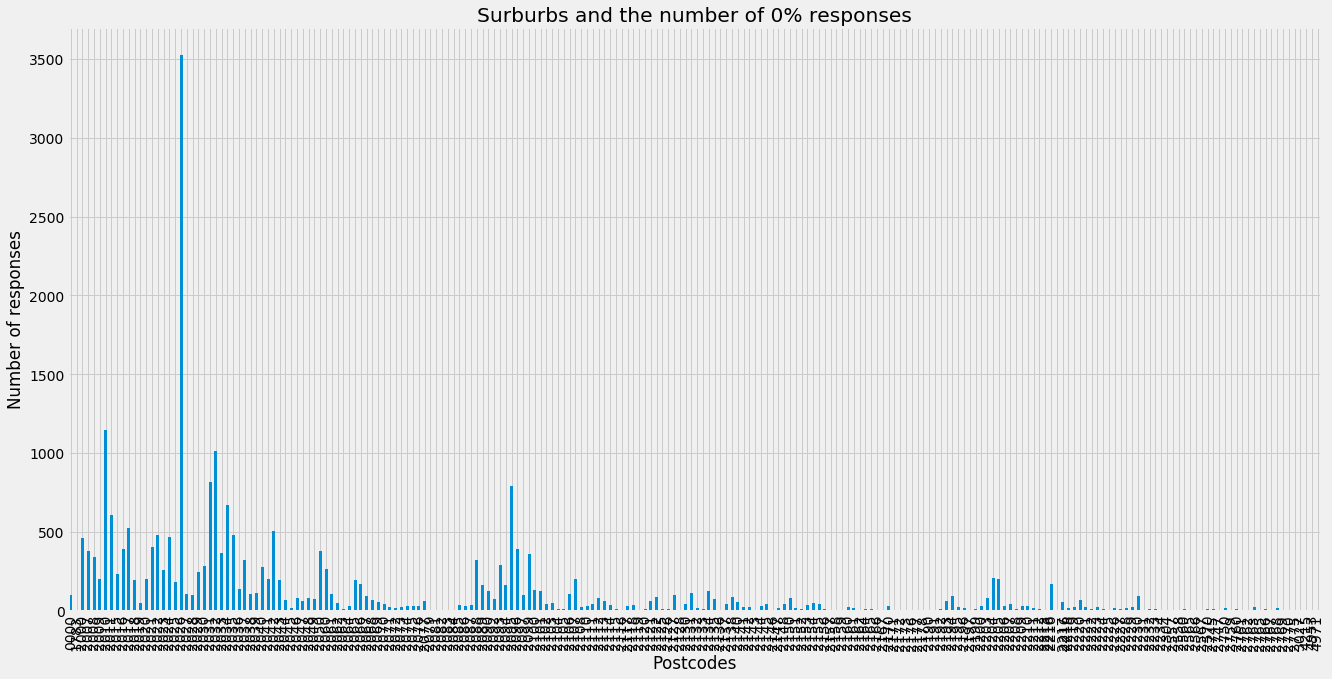

In [25]:
which_suburb_zero_responses = zeroresponse.groupby("simple_postcode").sum().host_listings_count.plot(kind="bar")
plt.title('Surburbs and the number of 0% responses')
plt.ylabel('Number of responses')
plt.xlabel('Postcodes')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [26]:
zero_response_sum = zeroresponse.groupby("simple_postcode").sum()

Text(0.5, 0, 'Postcode')

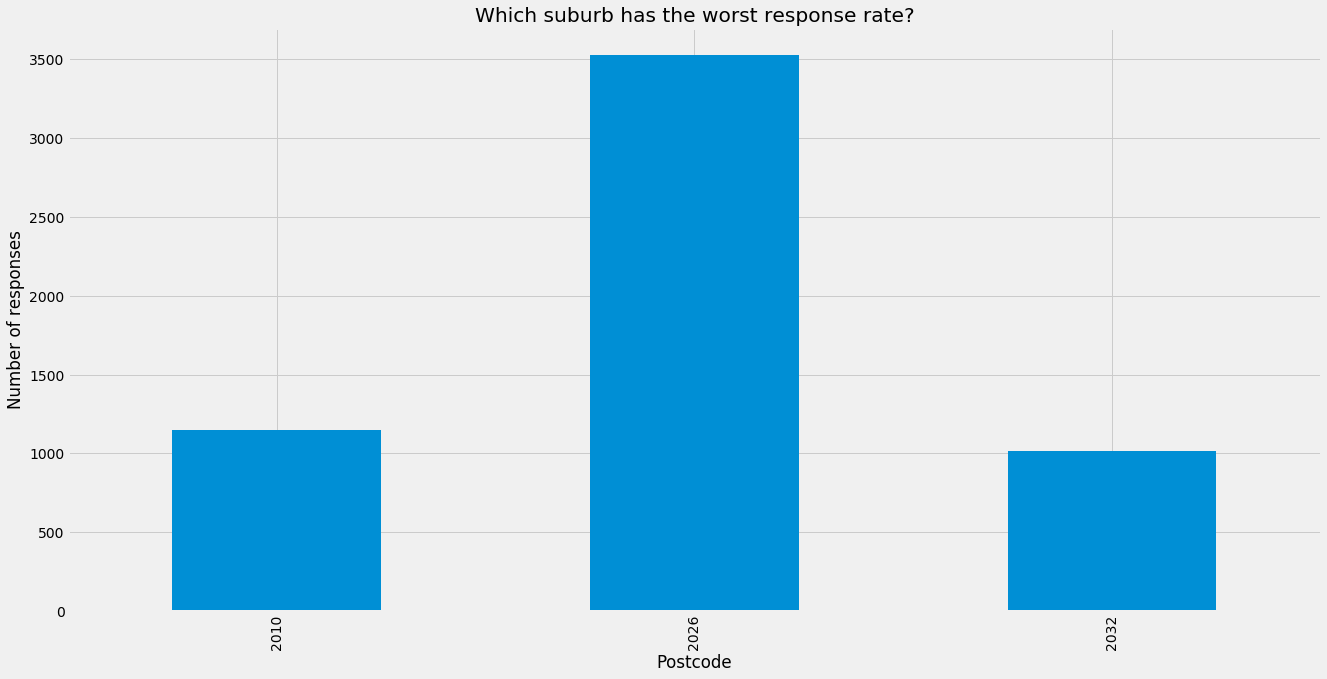

In [27]:
# which suburb has the worst response rate?
hl = zero_response_sum["host_total_listings_count"].value_counts()
zero_response_sum["host_total_listings_count"][zero_response_sum["host_total_listings_count"]>1000].plot(kind="bar")
plt.title("Which suburb has the worst response rate?")
plt.ylabel('Number of responses')
plt.xlabel('Postcode')

## Number of Airbnbs in each city
> Bondi Beach seems to have the highest number of airbnbs at first analysis. 

In [28]:
# how many cities are there?
air_bnb["city"].value_counts()

Bondi Beach            1947
Surry Hills            1366
Manly                  1254
Sydney                 1074
Bondi                   978
                       ... 
Bilgola, Sydney           1
warriewood Beach          1
Girraween                 1
Ku-Ring-Gai Council       1
Lilyfield                 1
Name: city, Length: 833, dtype: int64

Text(0.5, 0, 'City name')

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 24713 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 23612 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 30707 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 35895 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 24066 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 50924 missing from current font.

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/b

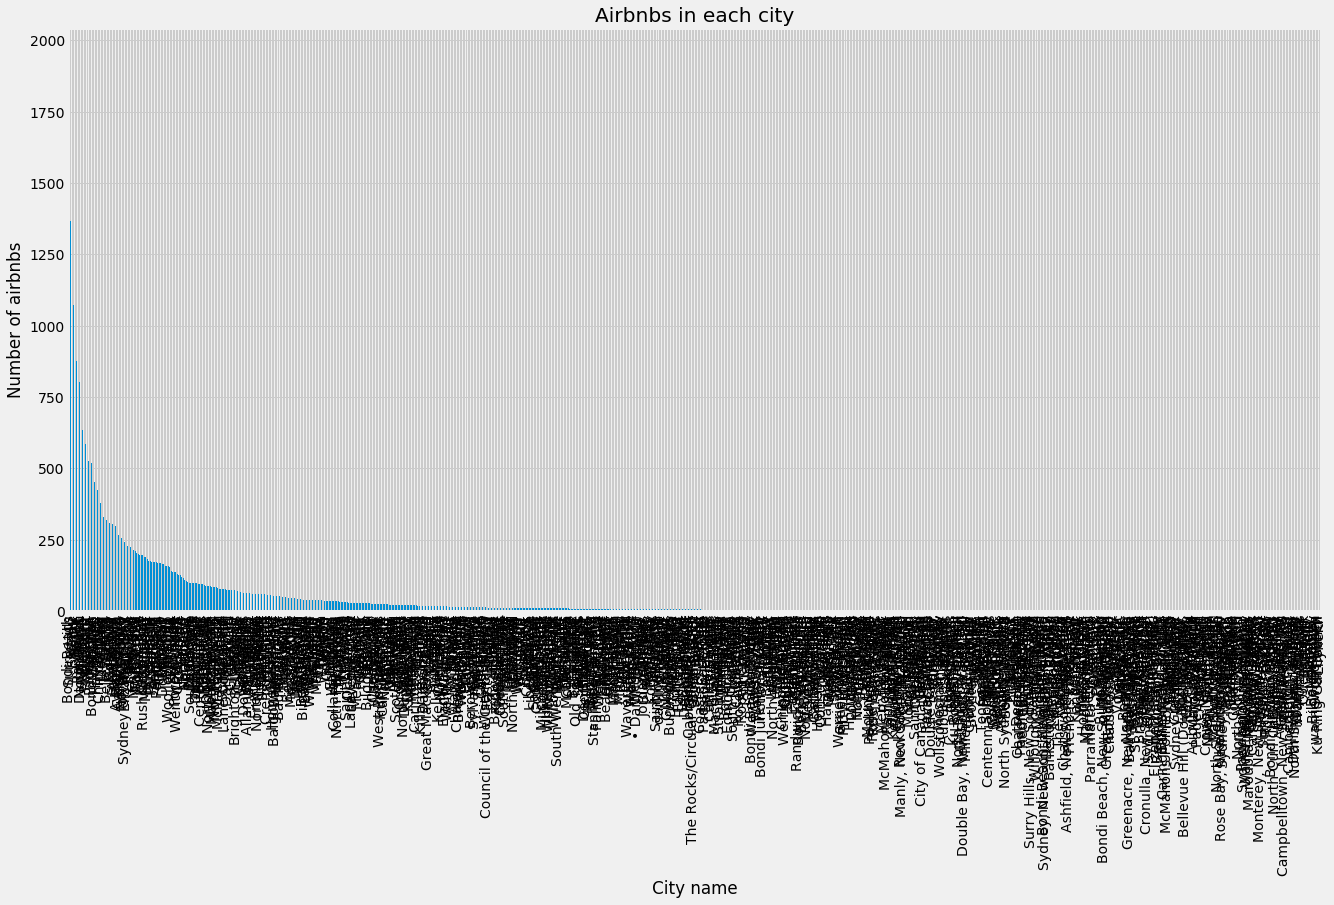

In [29]:
# How many airbnbs in each city?
air_bnb["city"].value_counts().plot(kind="bar");
plt.title("Airbnbs in each city")
plt.ylabel('Number of airbnbs')
plt.xlabel('City name')

## What are the cancellation policies?

In [30]:
# what type of cancellation policies were there?
air_bnb["cancellation_policy"].value_counts()

strict_14_with_grace_period    15367
flexible                       13924
moderate                        8587
super_strict_60                  111
super_strict_30                   67
luxury_super_strict_125            8
luxury_no_refund                   7
luxury_moderate                    7
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64

Text(0.5, 0, 'Catergoies of Cancellation Policy')

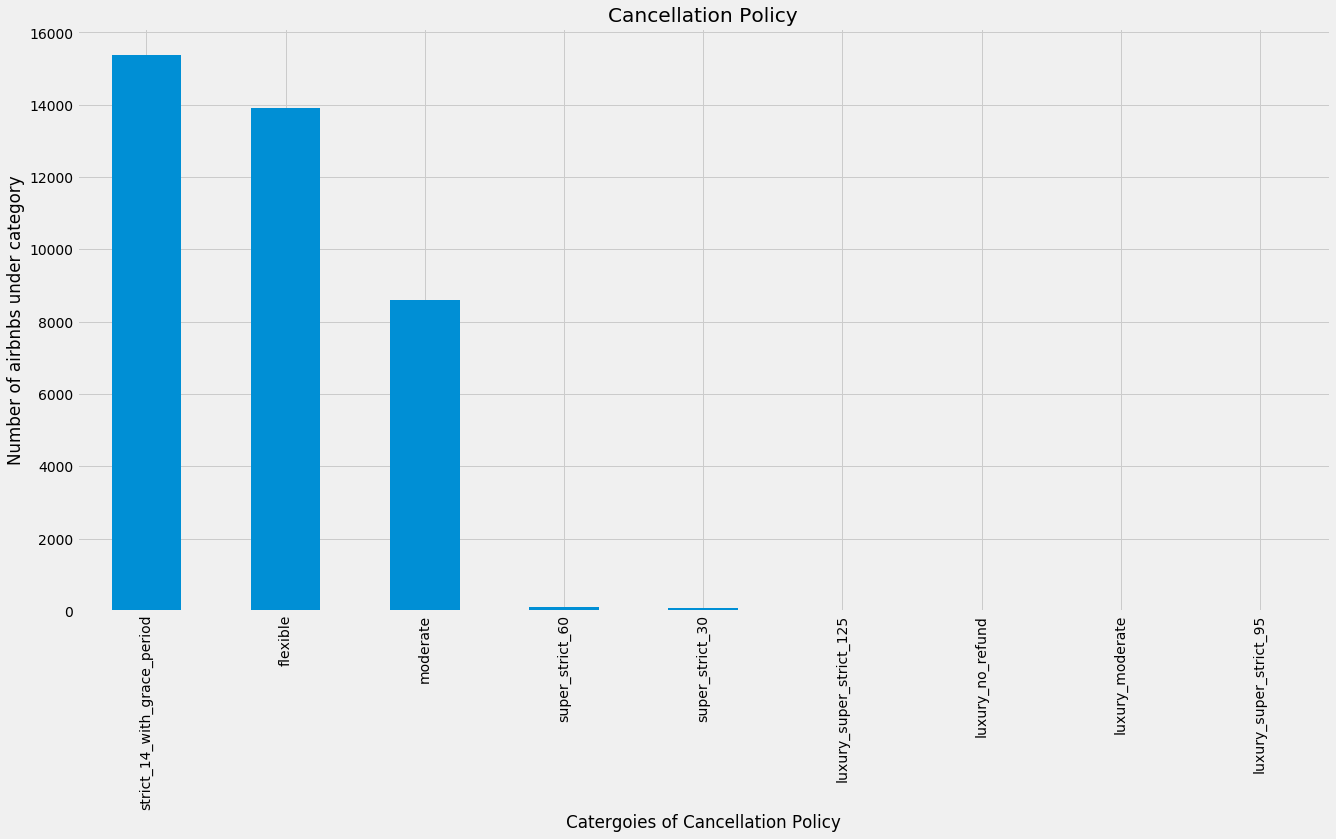

In [31]:
cancellation = air_bnb["cancellation_policy"].value_counts().plot(kind="bar")
plt.title('Cancellation Policy')
plt.ylabel('Number of airbnbs under category')
plt.xlabel('Catergoies of Cancellation Policy')

## Do any of the Airbnbs offer experiences?
> Seems like no airbnbs offer any experiences. 

In [32]:
air_bnb["experiences_offered"].value_counts()

none    38080
Name: experiences_offered, dtype: int64

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



Text(0.5, 0, 'Experiences')

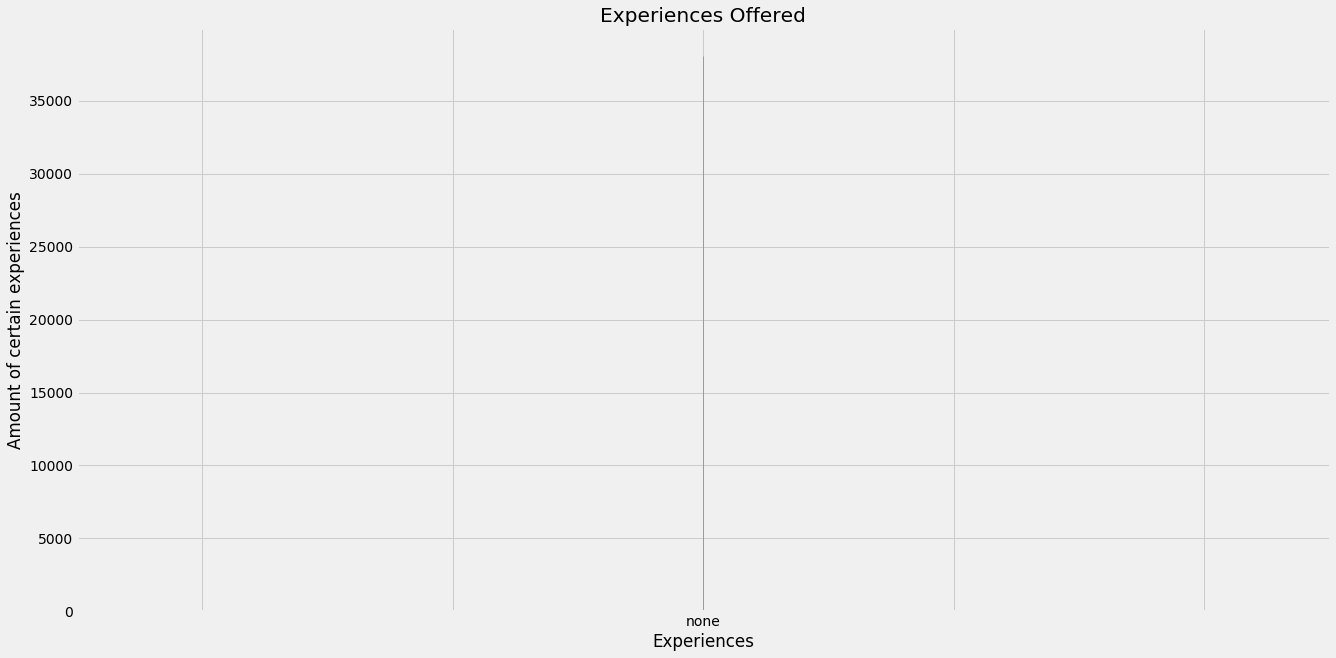

In [33]:
# did any airbnbs offer experiences?
experiences = air_bnb["experiences_offered"].value_counts().plot(kind="area");
plt.title('Experiences Offered')
plt.ylabel('Amount of certain experiences')
plt.xlabel('Experiences')

## What beds do hosts usually provide?
> What kinds of beds are there? 

Text(0.5, 0, 'Types of Bed')

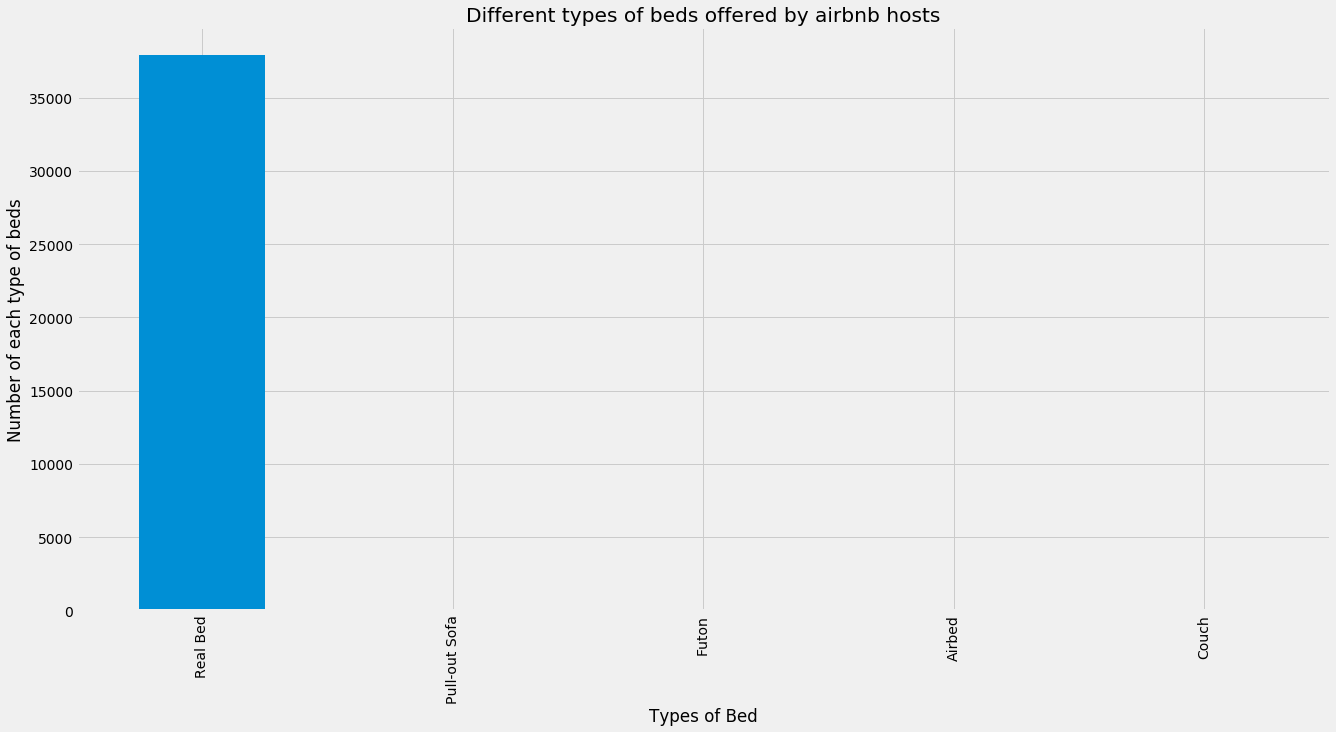

In [34]:
# different bed types offered by airbnb hosts 
diff_bed_types = air_bnb["bed_type"].value_counts().plot(kind="bar")
plt.title('Different types of beds offered by airbnb hosts')
plt.ylabel('Number of each type of beds')
plt.xlabel('Types of Bed')

In [35]:
# how many futon beds are there?
def find_futon_number(column):
    count = 0
    for x in column:
        if x =="Futon":
            count+=1
#             print(count)
    return count
            
find_futon_number(air_bnb.bed_type)
# air_bnb["bed_type"== Futon].value_counts().plot(kind="bar")

41

In [36]:
# What suburb are they in?
def futon_suburb(column):
    for x in column:
        if x =="Futon":
            return True
    return False

futon_suburb(air_bnb.bed_type)

True

In [37]:
air_bnb["Futon"] = air_bnb.apply(futon_suburb,axis=1)

In [38]:
# finding out which suburb the futons are located in
# a file of all the airbnbs with futons
futonBNB = air_bnb[air_bnb["Futon"]]

In [39]:
futonBNB

id                            listing_url       scrape_id  \
110      315059    https://www.airbnb.com/rooms/315059  20190710033517   
188      496747    https://www.airbnb.com/rooms/496747  20190710033517   
1121    2140246   https://www.airbnb.com/rooms/2140246  20190710033517   
1606    3210540   https://www.airbnb.com/rooms/3210540  20190710033517   
1698    3449802   https://www.airbnb.com/rooms/3449802  20190710033517   
2649    4739402   https://www.airbnb.com/rooms/4739402  20190710033517   
2711    4779185   https://www.airbnb.com/rooms/4779185  20190710033517   
3097    5230652   https://www.airbnb.com/rooms/5230652  20190710033517   
3136    5288902   https://www.airbnb.com/rooms/5288902  20190710033517   
3666    6134420   https://www.airbnb.com/rooms/6134420  20190710033517   
3792    6348422   https://www.airbnb.com/rooms/6348422  20190710033517   
3910    6495371   https://www.airbnb.com/rooms/6495371  20190710033517   
4296    7060893   https://www.airbnb.com/rooms/7060893  20190710033517   
4429    7331273   https://www.airbnb.com/rooms/7331273  20190710033517   
4601    7652264   https://www.airbnb.com/rooms/7652264  20190710033517   
5104    8417279   https://www.airbnb.com/rooms/8417279  20190710033517   
5555    9012813   https://www.airbnb.com/rooms/9012813  20190710033517   
5834    9242045   https://www.airbnb.com/rooms/9242045  20190710033517   
5844    9259004   https://www.airbnb.com/rooms/9259004  20190710033517   
6032    9395110   https://www.airbnb.com/rooms/9395110  20190710033517   
7381   10212039  https://www.airbnb.com/rooms/10212039  20190710033517   
8094   11325465  https://www.airbnb.com/rooms/11325465  20190710033517   
8404   11760748  https://www.airbnb.com/rooms/11760748  20190710033517   
8699   12190940  https://www.airbnb.com/rooms/12190940  20190710033517   
8990   12692174  https://www.airbnb.com/rooms/12692174  20190710033517   
9804   13629326  https://www.airbnb.com/rooms/13629326  20190710033517   
9848   13694461  https://www.airbnb.com/rooms/13694461  20190710033517   
9875   13720195  https://www.airbnb.com/rooms/13720195  20190710033517   
9886   13736307  https://www.airbnb.com/rooms/13736307  20190710033517   
10057  13941758  https://www.airbnb.com/rooms/13941758  20190710033517   
10154  14076297  https://www.airbnb.com/rooms/14076297  20190710033517   
11096  15331992  https://www.airbnb.com/rooms/15331992  20190710033517   
13999  17611591  https://www.airbnb.com/rooms/17611591  20190710033517   
16142  19939776  https://www.airbnb.com/rooms/19939776  20190710033517   
16258  20058436  https://www.airbnb.com/rooms/20058436  20190710033517   
16920  20728803  https://www.airbnb.com/rooms/20728803  20190710033517   
17459  21118691  https://www.airbnb.com/rooms/21118691  20190710033517   
17519  21165925  https://www.airbnb.com/rooms/21165925  20190710033517   
19471  21999536  https://www.airbnb.com/rooms/21999536  20190710033517   
21003  22520914  https://www.airbnb.com/rooms/22520914  20190710033517   
32448  32388997  https://www.airbnb.com/rooms/32388997  20190710033517   

      last_scraped                                               name  \
110     2019-07-11                     Stylish Home In Great Location   
188     2019-07-10                   Bondi, Sydney, room in cosy flat   
1121    2019-07-10                        Quiet, convenient apartment   
1606    2019-07-10                     Cool City Pad in Circular Quay   
1698    2019-07-10  Xmas in spacious Terrace house with garden & d...   
2649    2019-07-11                Marrickville Modern  An Urban Oasis   
2711    2019-07-10                  Private Garden Studio by the Pool   
3097    2019-07-10                       Charming  Art Deco Apartment   
3136    2019-07-10                      Large Art Deco - At the Beach   
3666    2019-07-10                  Single bed mattress private room.   
3792    2019-07-10                                         The Manor-   
3910    2019-07-11          

Text(0.5, 0, 'Postcode')

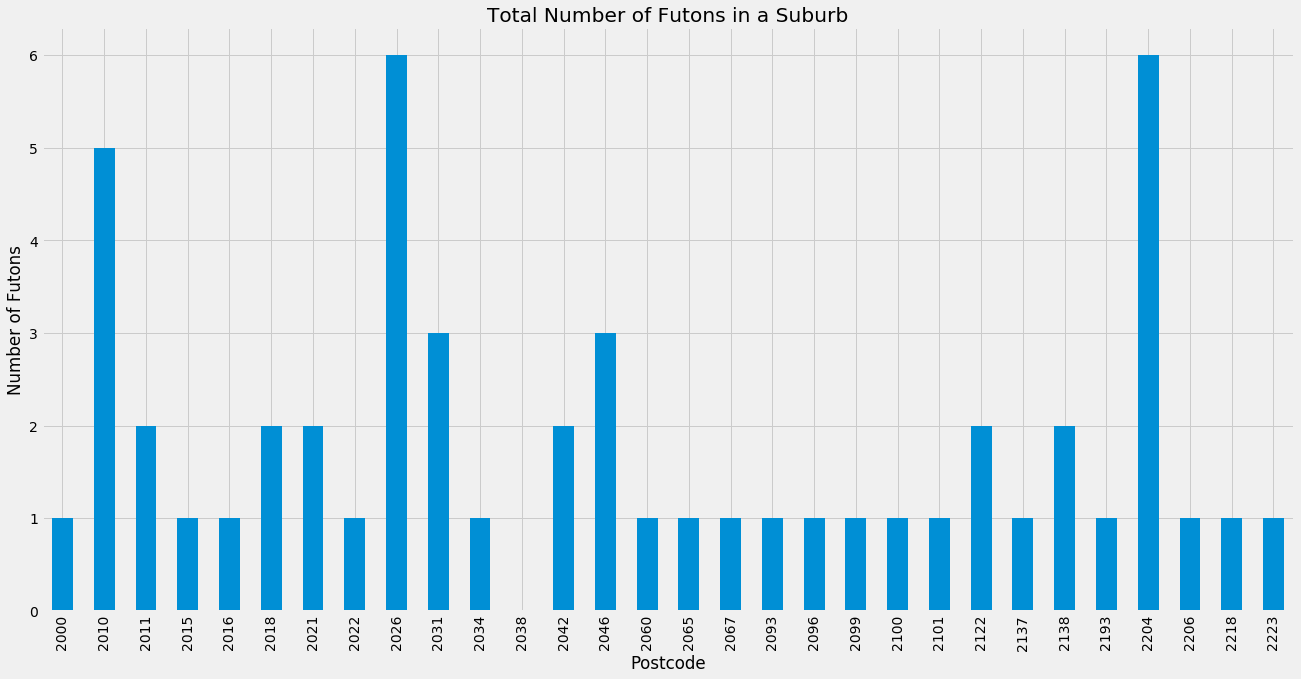

In [40]:
sum_of_futon_in_suburb = futonBNB.groupby("simple_postcode").sum().host_listings_count.plot(kind="bar")
plt.title('Total Number of Futons in a Suburb')
plt.ylabel('Number of Futons')
plt.xlabel('Postcode')

> The Futons are spread evenly across NSW.

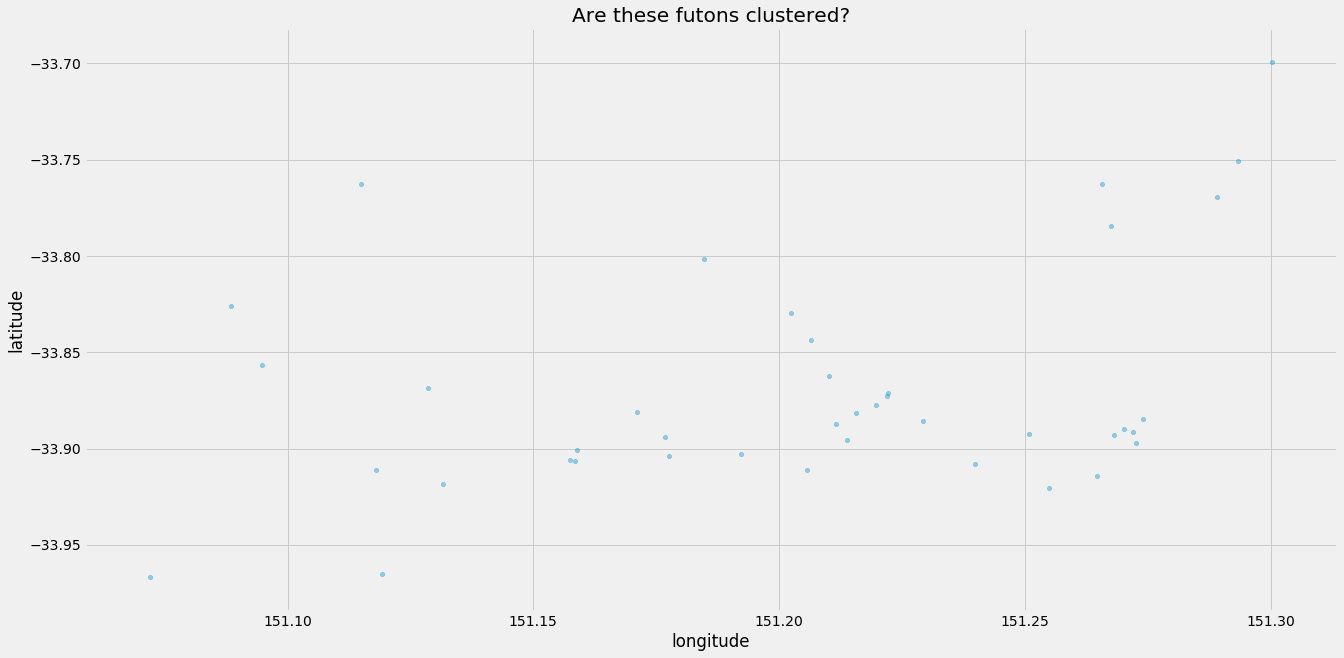

In [41]:
# Where the futons are
wherefutons = futonBNB.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.title('Are these futons clustered?')
plt.show()

Text(0.5, 1, 'NORTH BONDI')

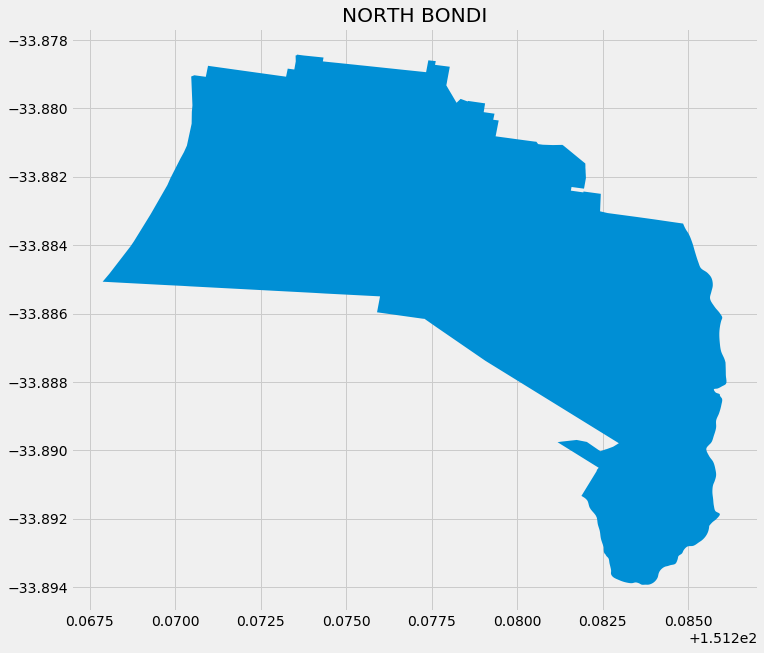

In [42]:
# Suburbs with the highest amount of Futons
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
air_bnb_burbs = (burbs[burbs.NSW_LOCA_2 == "NORTH BONDI"])
air_bnb_burbs.head()
air_bnb_burbs.plot()
plt.title("NORTH BONDI")

Text(0.5, 1, 'MARRICKVILLE')

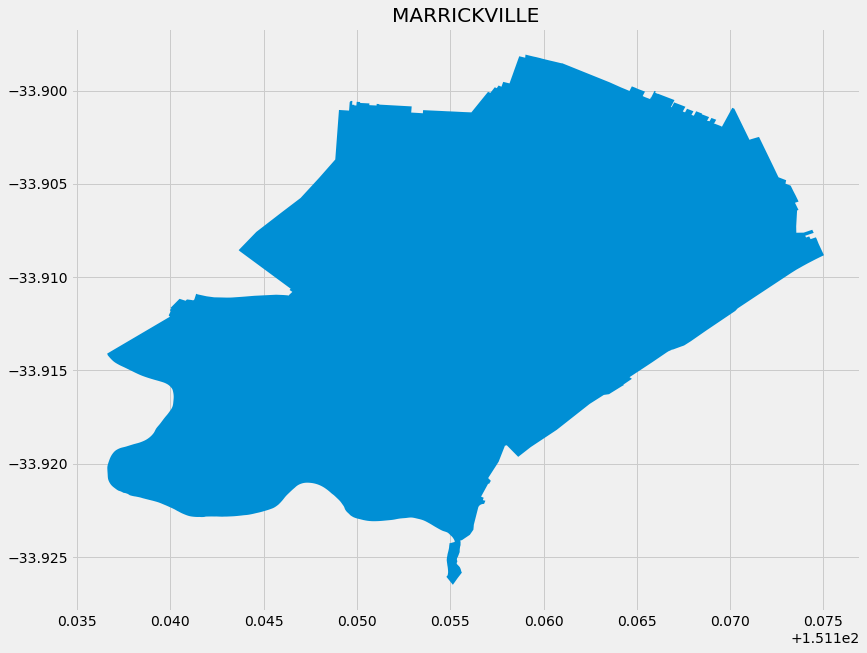

In [43]:
# which suburb has the most futons
burbs = gp.GeoDataFrame.from_file(shp_file_name)
air_bnb_burbs = burbs[burbs.NSW_LOCA_2 == "MARRICKVILLE"]
air_bnb_burbs.head()
air_bnb_burbs.plot()
plt.title("MARRICKVILLE")

### Where do those hosts live?
> With the exception of some not providing their location, most hosts live in Sydney City. 

Text(0.5, 0, 'Suburb')

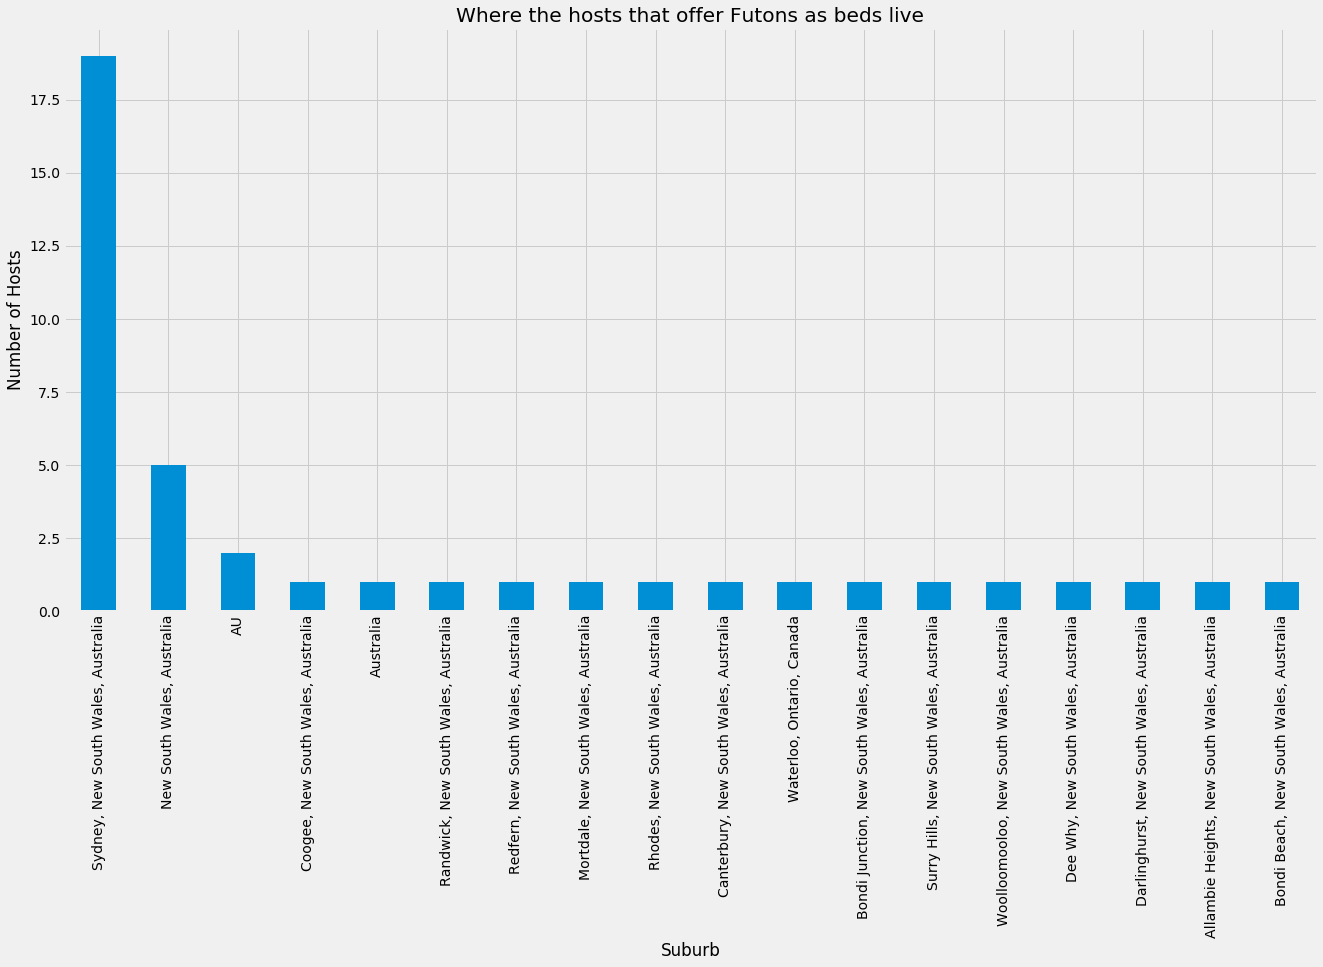

In [44]:
futonBNB["host_location"].value_counts().plot(kind="bar");
plt.title("Where the hosts that offer Futons as beds live")
plt.ylabel('Number of Hosts')
plt.xlabel('Suburb')

## What types of accommodation is offered?

Text(0.5, 0, 'Types of airbnbs')

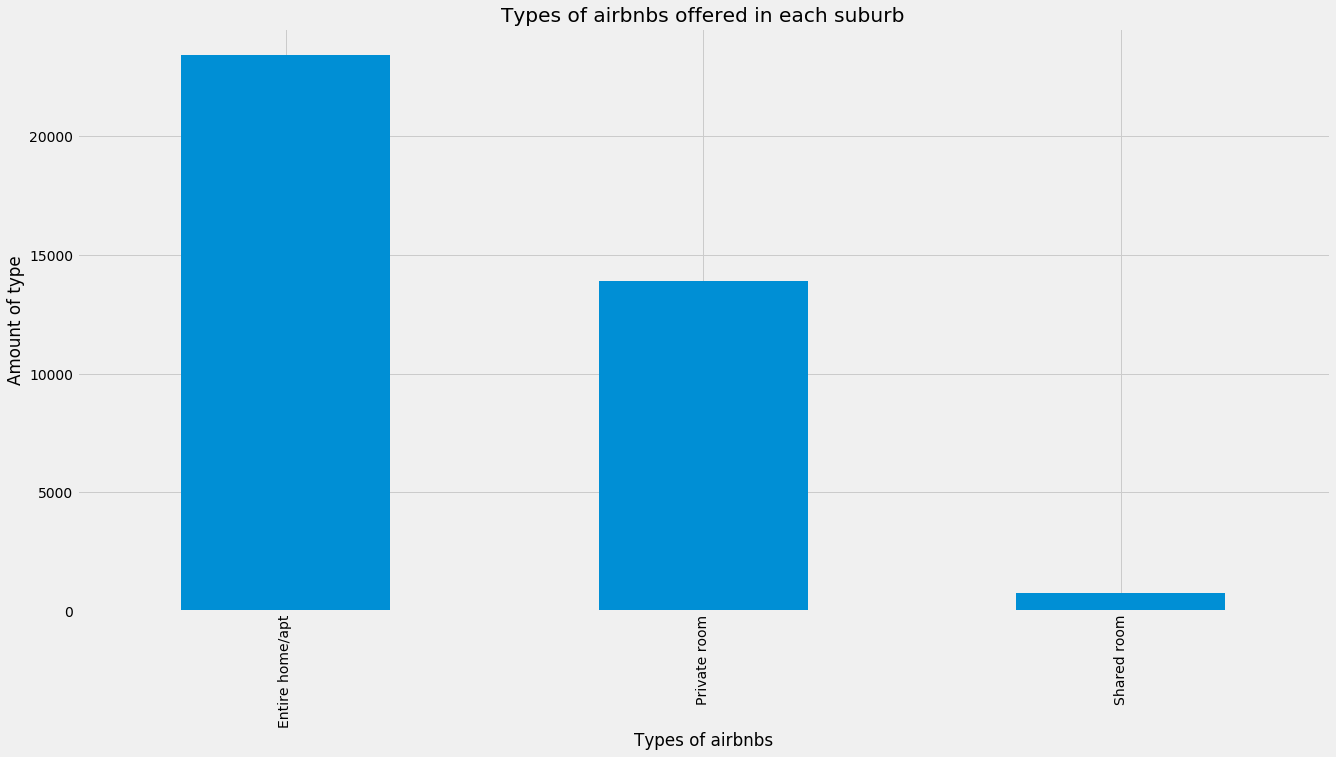

In [45]:
# different types of accomodation offered 
air_bnb["room_type"].value_counts().plot(kind="bar")
plt.title("Types of airbnbs offered in each suburb")
plt.ylabel('Amount of type')
plt.xlabel('Types of airbnbs')

In [46]:
# is it an entire home, private room or shared room?
def entirehome(column):
    for x in column:
        if x =="Entire home/apt":
            return True
    return False
    
entirehome(air_bnb.room_type)

True

In [47]:
air_bnb["Entire_home"] = air_bnb.apply(entirehome,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
27636  29426959  https://www.airbnb.com/rooms/29426959  20190710033517   
33846  33477159  https://www.airbnb.com/rooms/33477159  20190710033517   
15163  18977243  https://www.airbnb.com/rooms/18977243  20190710033517   
29671  30454771  https://www.airbnb.com/rooms/30454771  20190710033517   
19530  22026108  https://www.airbnb.com/rooms/22026108  20190710033517   

      last_scraped                                           name  \
27636   2019-07-11  Minutes to Starcity and ICC. Luxurious House.   
33846   2019-07-10                              Cozy Family House   
15163   2019-07-10   spacious room with ensuite 5 mins from manly   
29671   2019-07-11   Shared Bedroom in a Guest house at Milky Way   
19530   2019-07-10  Beautiful 4 beds house close to blue mountain   

                                                 summary  \
27636  Perfect location to explore Sydney. 5 minutes ...   
33846  Come and stay at this beautifully designed fam...   
15163  beautifully furnished townhouse in tranquil su...   
29671  I am offering a bedroom shared in newly built ...   
19530  In a very safe district, close to shopping cen...   

                                                   space  \
27636  Very rare large spacious terrace home in Harbo...   
33846  * Only 5km (11 min drive)away from Bankwest St...   
15163                                                NaN   
29671  1. Close to Everything: 2 Min Drive to Highway...   
19530                                                NaN   

                                             description experiences_offered  \
27636  Perfect location to explore Sydney. 5 minutes ...                none   
33846  Come and stay at this beautifully designed fam...                none   
15163  beautifully furnished townhouse in tranquil su...                none   
29671  I am offering a bedroom shared in newly built ...                none   
19530  In a very safe district, close to shopping cen...                none   

                                   neighborhood_overview  \
27636  Beautiful harbourside suburb Peaceful and quie...   
33846                 Close to local Coffee shops & park   
15163                                                NaN   
29671  It is a newly developed suburb with a lot open...   
19530                                                NaN   

                                                   notes  \
27636  Please ensure respectful to other residents 1....   
33846                                                NaN   
15163                                                NaN   
29671  Landlord House is adjacent to our guest house....   
19530                                                NaN   

                                                 transit  \
27636  Light rail is literally almost at your door st...   
33846      Close to Telopea train station, and bus stop.   
15163                                                NaN   
29671  10 Min walk to Macarthur Train Station / Bus S...   
19530                                                NaN   

                                                  access  \
27636                                                NaN   
33846                                                NaN   
15163                                                NaN   
29671  We can share  1. Kitchen/ Living area 2. Bathr...   
19530                                                NaN   

                                             interaction  \
27636  I always setup a (Hidden by Airbnb) or (Hidden...   
33846                                                NaN   
15163                                                NaN   
29671                                                NaN   
19530                                                NaN   

                                             house_rules  thumbnail_url  \
27636                                                NaN            Na

In [48]:
entirehomeBNB = air_bnb[air_bnb["Entire_home"]]

Text(0.5, 0, 'Suburb')

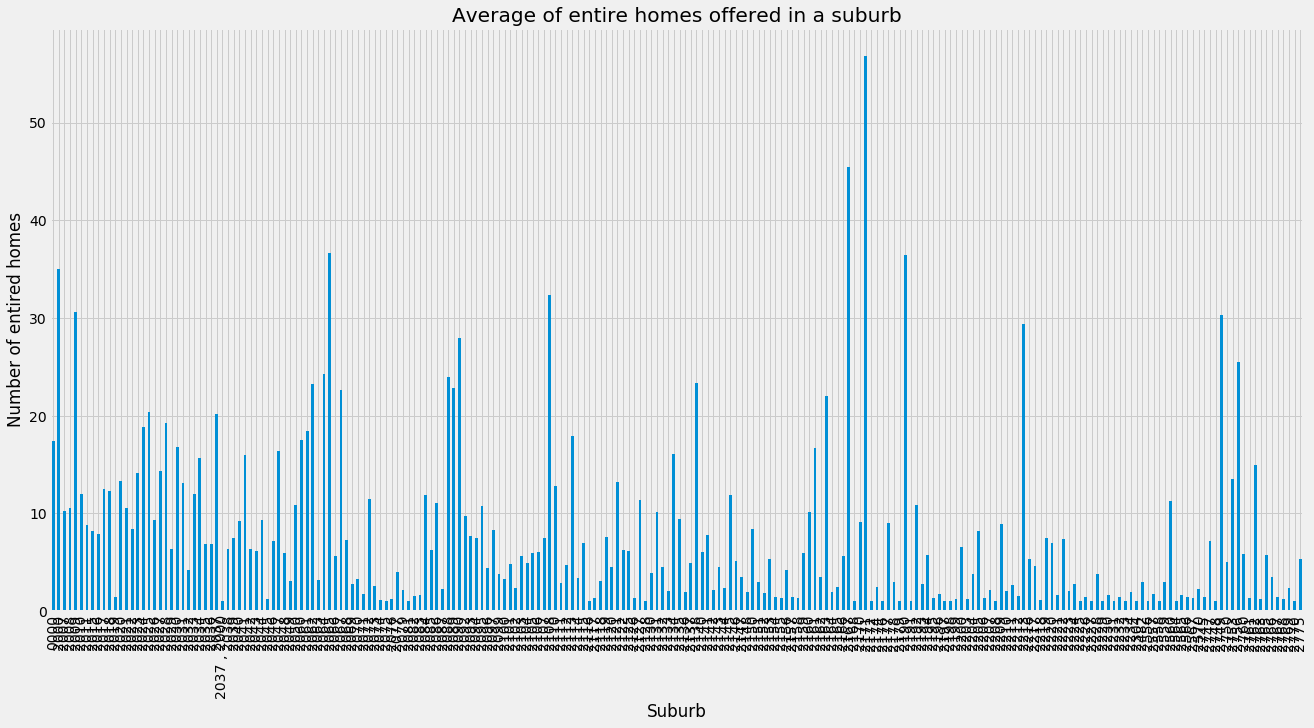

In [49]:
mean_of_entirehomes_in_suburb = entirehomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar")
plt.title("Average of entire homes offered in a suburb")
plt.ylabel('Number of entired homes')
plt.xlabel('Suburb')

In [50]:
# is it an entire home or shared room?
def sharedhome(column):
    for x in column:
        if x =="Private room" or x =="Shared room":
            return True
    return False

sharedhome(air_bnb.room_type)

True

In [51]:
air_bnb["Shared"] = air_bnb.apply(sharedhome,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
14774  18508154  https://www.airbnb.com/rooms/18508154  20190710033517   
4380    7245992   https://www.airbnb.com/rooms/7245992  20190710033517   
29279  30297569  https://www.airbnb.com/rooms/30297569  20190710033517   
8694   12176184  https://www.airbnb.com/rooms/12176184  20190710033517   
10429  14524713  https://www.airbnb.com/rooms/14524713  20190710033517   

      last_scraped                                        name  \
14774   2019-07-10   Bondi 4 Bedroom Semi with Modern Finishes   
4380    2019-07-10          One block from iconic Bondi Beach!   
29279   2019-07-11  Home away from home, just 10 mins from CBD   
8694    2019-07-11            Private studio in great location   
10429   2019-07-10                Modern Family Home with Pool   

                                                 summary  \
14774  A conveniently located Bondi 4 bedroom house (...   
4380   Situated one block from Bondi Beach, this fant...   
29279  Beautiful quaint Sydney workman's cottage - li...   
8694   A sustainable sunny single room studio, set in...   
10429  Greenwich, one of the most liveable suburbs in...   

                                                   space  \
14774                                Maximum of 8 Guests   
4380                                                 NaN   
29279  This is the perfect base for a family or profe...   
8694   The studio is set away from the main house, ne...   
10429                                                NaN   

                                             description experiences_offered  \
14774  A conveniently located Bondi 4 bedroom house (...                none   
4380   Situated one block from Bondi Beach, this fant...                none   
29279  Beautiful quaint Sydney workman's cottage - li...                none   
8694   A sustainable sunny single room studio, set in...                none   
10429  Greenwich, one of the most liveable suburbs in...                none   

                                   neighborhood_overview  \
14774                                                NaN   
4380                                                 NaN   
29279  The house is located in the leafy inner-west s...   
8694   Shops and some restaurants are located nearby ...   
10429                                                NaN   

                                                   notes  \
14774                                                NaN   
4380                                                 NaN   
29279  If you are travelling with a baby, we're happy...   
8694                                                 NaN   
10429                                                NaN   

                                                 transit  \
14774                                                NaN   
4380                                                 NaN   
29279  There are plenty of great bay walks within wal...   
8694   Well serviced train station is very close by (...   
10429                                                NaN   

                                                  access  \
14774                                                NaN   
4380                                                 NaN   
29279  Guests have access the entire house.  There is...   
8694   Please note that access to the studio is a lit...   
10429                                                NaN   

                                             interaction  \
14774                                                NaN   
4380                                                 NaN   
29279  We won't see guests as we are travelling, howe...   
8694   We live in the main house and are happy to pro...   
10429                                                NaN   

                                             house_rules  thumbnail_url  \
14774                                                NaN            NaN   
4380         

In [52]:
sharedhomeBNB = air_bnb[air_bnb["Shared"]]

In [53]:
sharedhomeBNB.sample(5)

id                            listing_url       scrape_id  \
15182  18985485  https://www.airbnb.com/rooms/18985485  20190710033517   
16392  20227095  https://www.airbnb.com/rooms/20227095  20190710033517   
3225    5425298   https://www.airbnb.com/rooms/5425298  20190710033517   
33089  32901565  https://www.airbnb.com/rooms/32901565  20190710033517   
22934  24122505  https://www.airbnb.com/rooms/24122505  20190710033517   

      last_scraped                                               name  \
15182   2019-07-10                             Perfect city comfort 3   
16392   2019-07-11  Portico Cottage Delightful garden, close to sh...   
3225    2019-07-10                  Quiet apartment near Bronte beach   
33089   2019-07-10                                 BONDI Private room   
22934   2019-07-10               Illawong quiet and comfortable house   

                                                 summary  \
15182                               Perfect city comfort   
16392                                                NaN   
3225   Light, leafy 2 bedroom apartment.  Quiet resid...   
33089  3 bedrooms, 2 bathroom appartement, located in...   
22934  good for backpacker or self-driving traveller....   

                                                   space  \
15182                                                NaN   
16392                                                NaN   
3225   My apartment is quiet and well-located.  10 mi...   
33089  you'll be sharing the place with 2 girls ( Iri...   
22934  2 private bright bedrooms available, one with ...   

                                             description experiences_offered  \
15182                               Perfect city comfort                none   
16392                                                NaN                none   
3225   Light, leafy 2 bedroom apartment.  Quiet resid...                none   
33089  3 bedrooms, 2 bathroom appartement, located in...                none   
22934  good for backpacker or self-driving traveller....                none   

                                   neighborhood_overview notes  \
15182                                                NaN   NaN   
16392                                                NaN   NaN   
3225   It's easy access to the wonderful beaches, res...   NaN   
33089                                                NaN   NaN   
22934  Our neighborhood is quiet and has lots of nati...   NaN   

                                                 transit  \
15182                                                NaN   
16392                                                NaN   
3225   Yes, as already mentioned, there are 2 separat...   
33089                                                NaN   
22934  The airport line is 10kms from our home. We ca...   

                                   access  \
15182                                 NaN   
16392                                 NaN   
3225   Everything is available to guests.   
33089                                 NaN   
22934                                 NaN   

                                             interaction  \
15182                                                NaN   
16392                                                NaN   
3225   Happy to enjoy a walk or a meal with guests wh...   
33089                                                NaN   
22934                                                NaN   

                                             house_rules  thumbnail_url  \
15182                                                NaN            NaN   
16392                                                NaN            NaN   
3225   No smoking in or outside the apartment.  I exp...            NaN   
33089                                                NaN            NaN   
22934                                                NaN            NaN   

       medium_url                                        picture_url  \
15182        

Text(0.5, 0, 'Suburb')

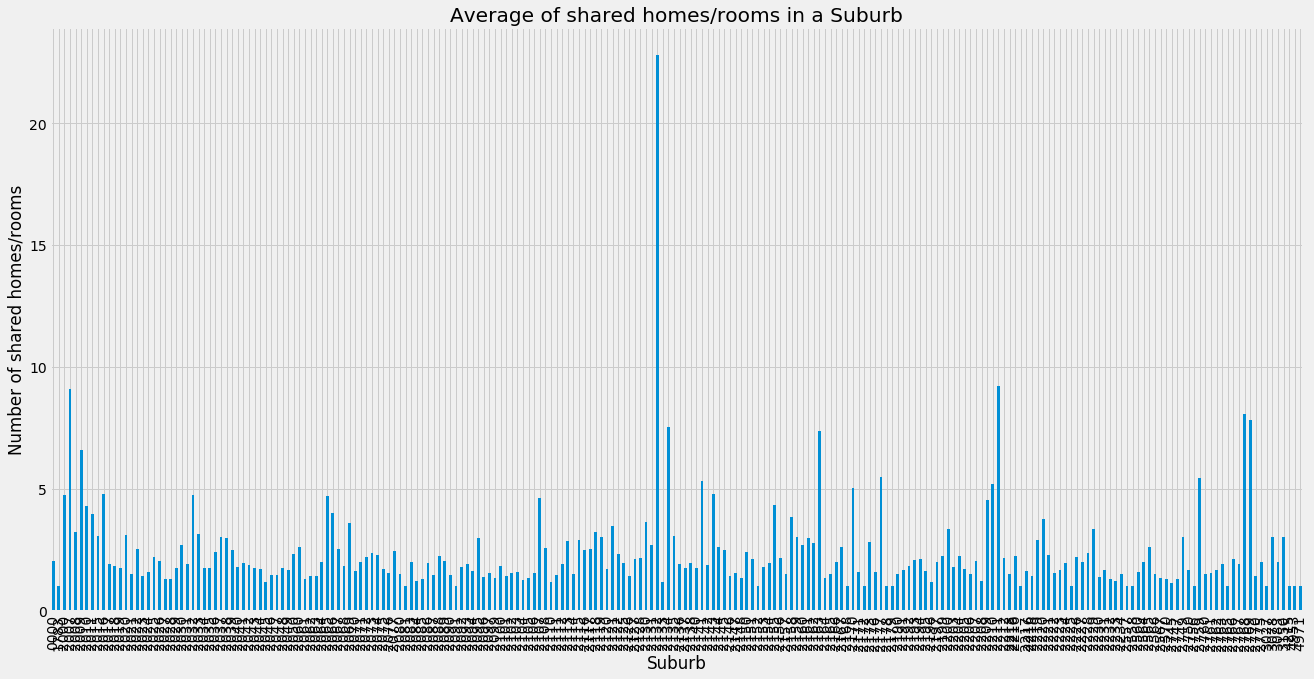

In [54]:
mean_of_sharedhomes_in_suburb = sharedhomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar")
plt.title("Average of shared homes/rooms in a Suburb")
plt.ylabel('Number of shared homes/rooms')
plt.xlabel('Suburb')

Text(0.5, 0, 'Bed types')

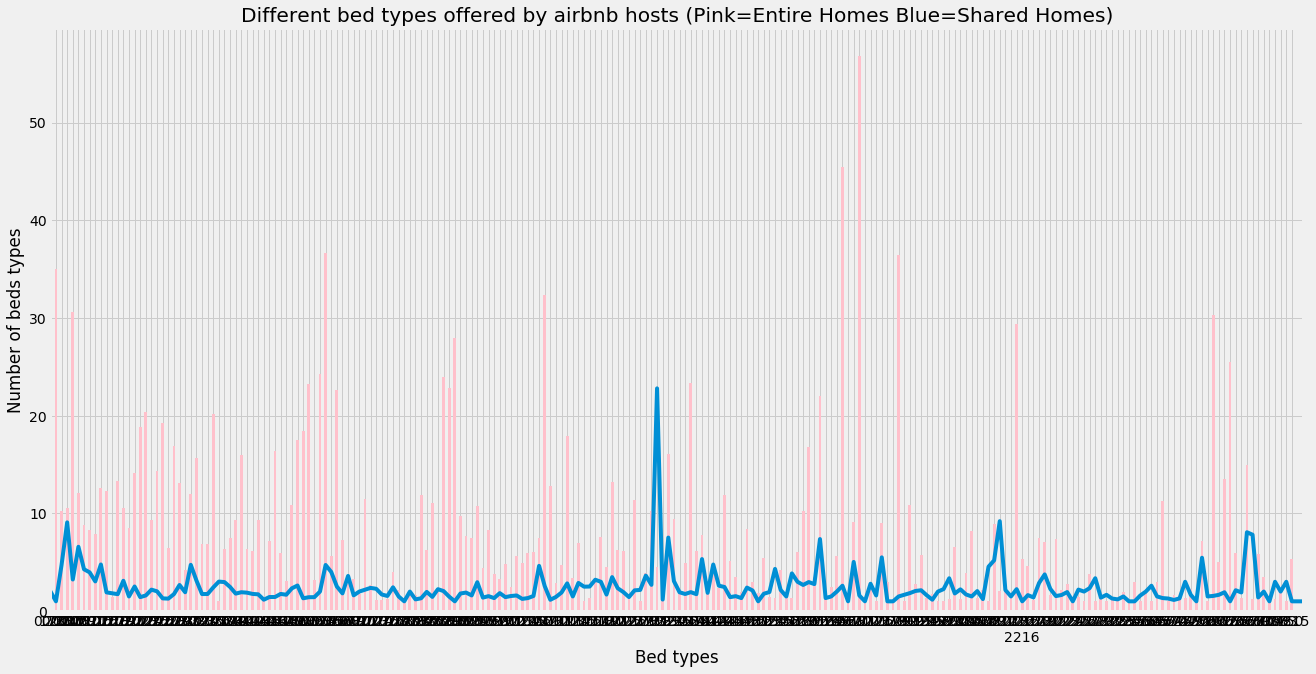

In [55]:
# ratio of entire homes to shared homes in different suburbs
mean_of_entirehomes_in_suburb = entirehomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar",facecolor='pink')
mean_of_sharedhomes_in_suburb = sharedhomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="line")
plt.title('Different bed types offered by airbnb hosts (Pink=Entire Homes Blue=Shared Homes)')
plt.ylabel('Number of beds types')
plt.xlabel('Bed types')

In [56]:
air_bnb.price = air_bnb.price.apply(float_str_to_int)

In [57]:
type(air_bnb.price.iloc[0])

numpy.int64

In [58]:
some_numbers = pd.Series(range(100))
some_numbers.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [59]:
some_numbers[some_numbers < 8]

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
dtype: int64

In [60]:
some_numbers[(some_numbers < 4) | (some_numbers > 97)]

0      0
1      1
2      2
3      3
98    98
99    99
dtype: int64

## Which suburbs have the least amount of Airbnbs?

In [61]:
air_bnb["zipcode"].value_counts()

2026           1988
2026.0         1952
2010.0         1164
2000.0         1137
2010           1022
               ... 
3083.0            1
2037 , 2000       1
2304              1
2128              1
3150.0            1
Name: zipcode, Length: 449, dtype: int64

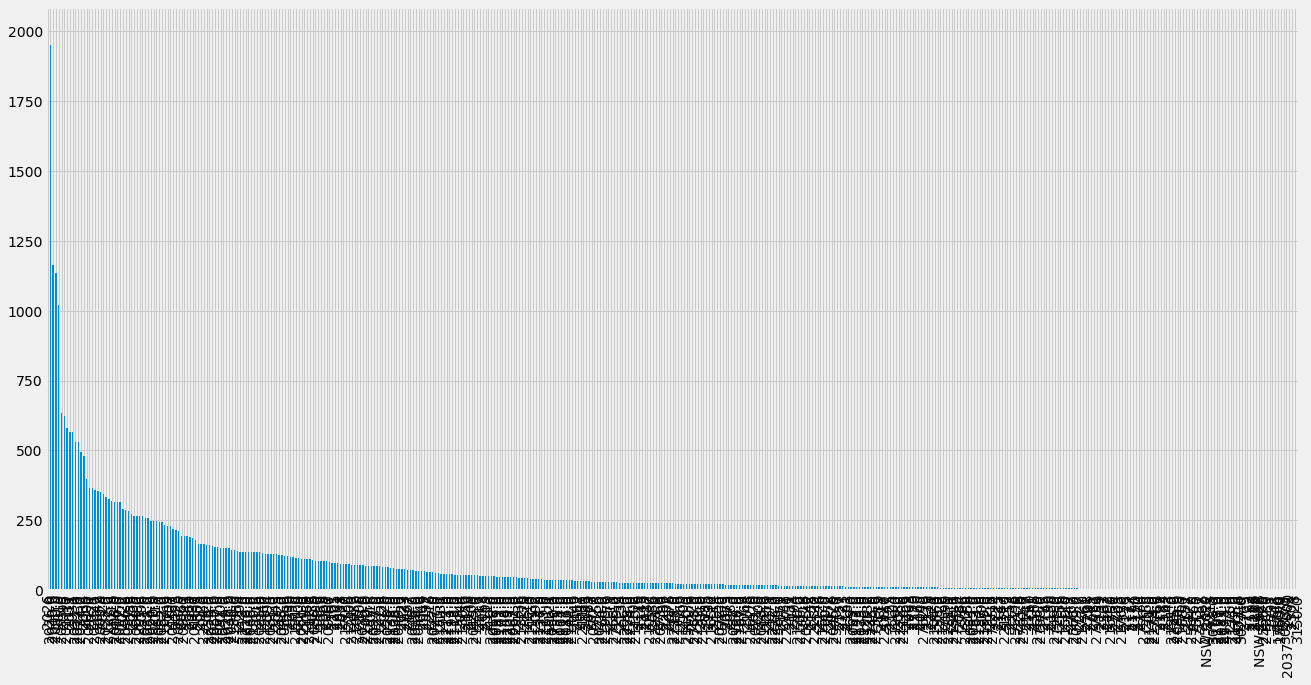

In [62]:
air_bnb["zipcode"].value_counts().plot(kind="bar")

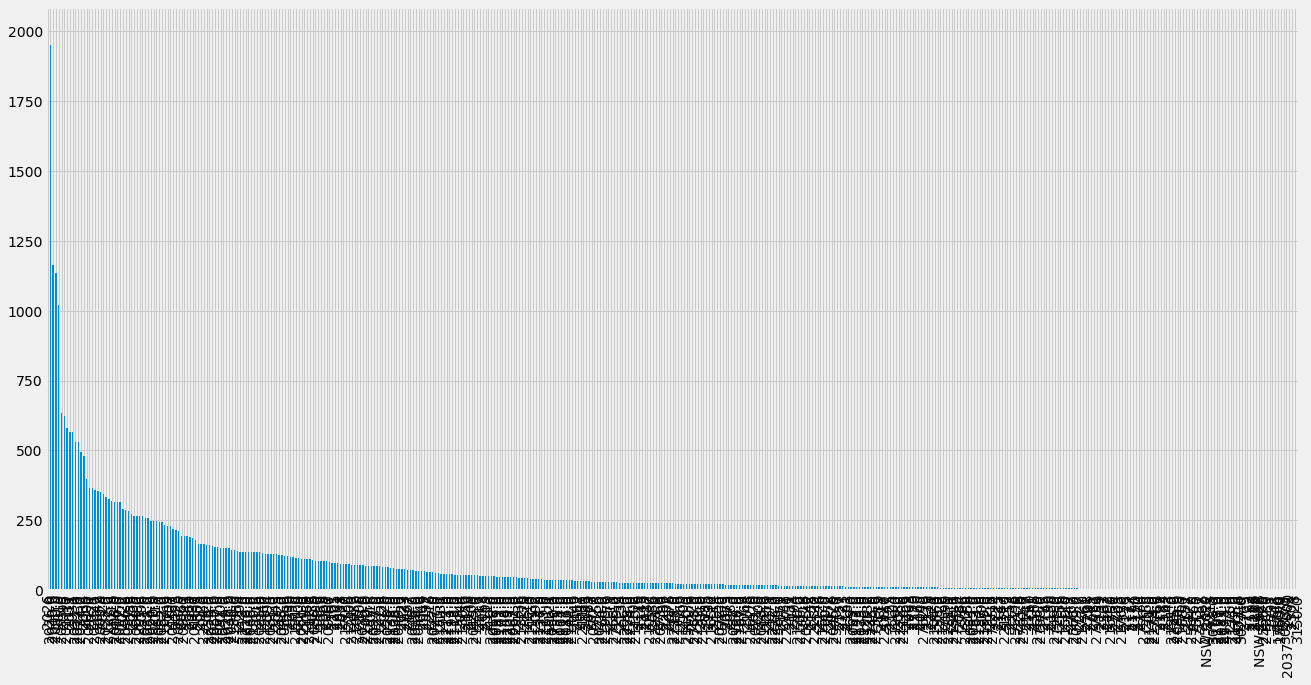

In [63]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 2000].plot(kind="bar")

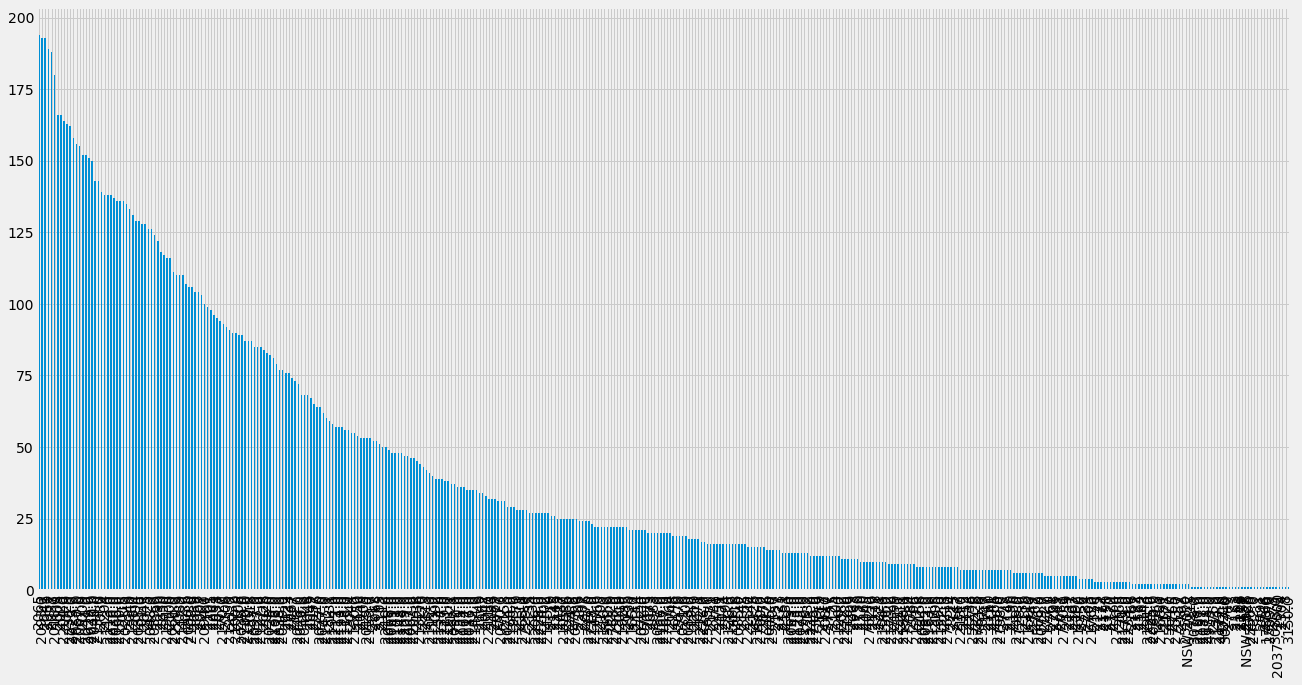

In [64]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 200].plot(kind="bar")

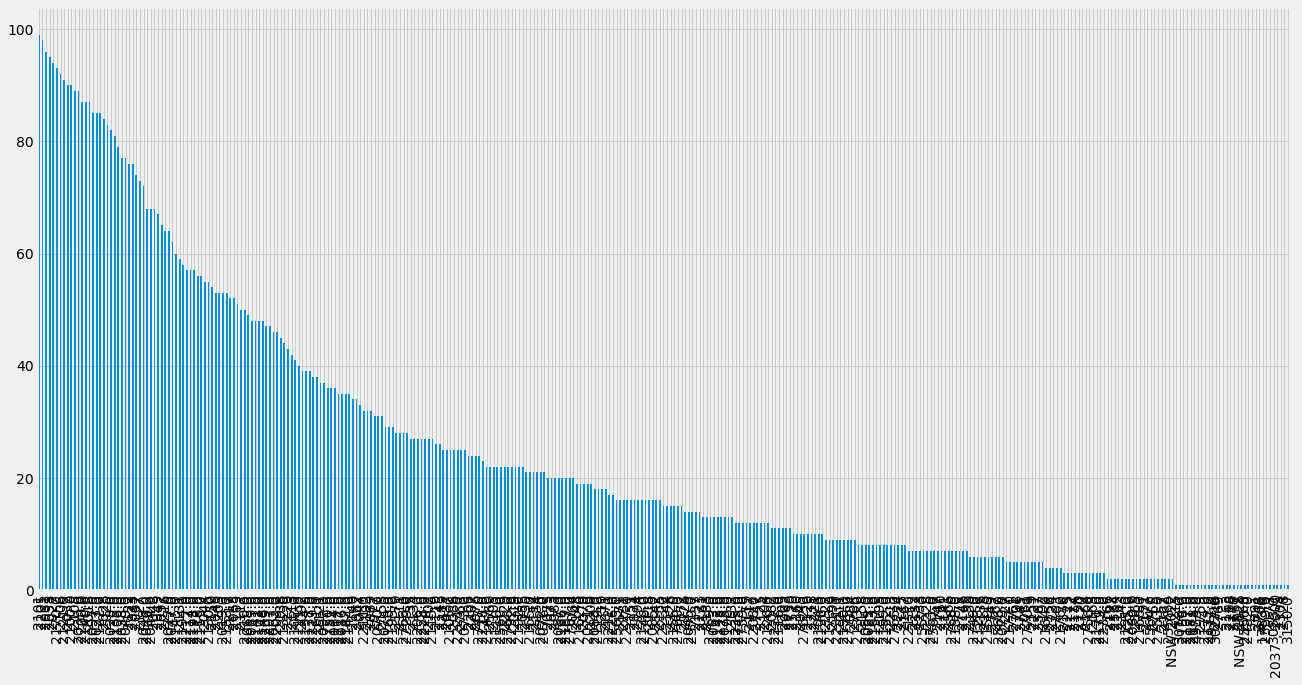

In [65]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 100].plot(kind="bar")

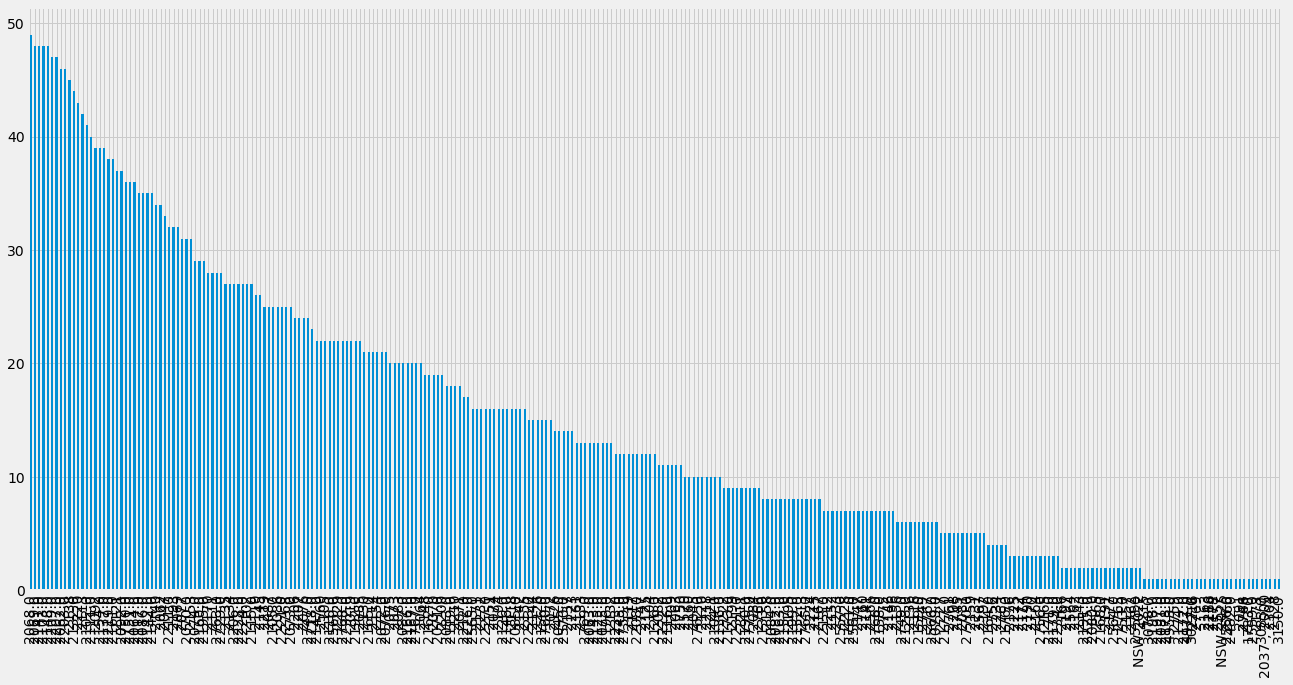

In [66]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 50].plot(kind="bar")

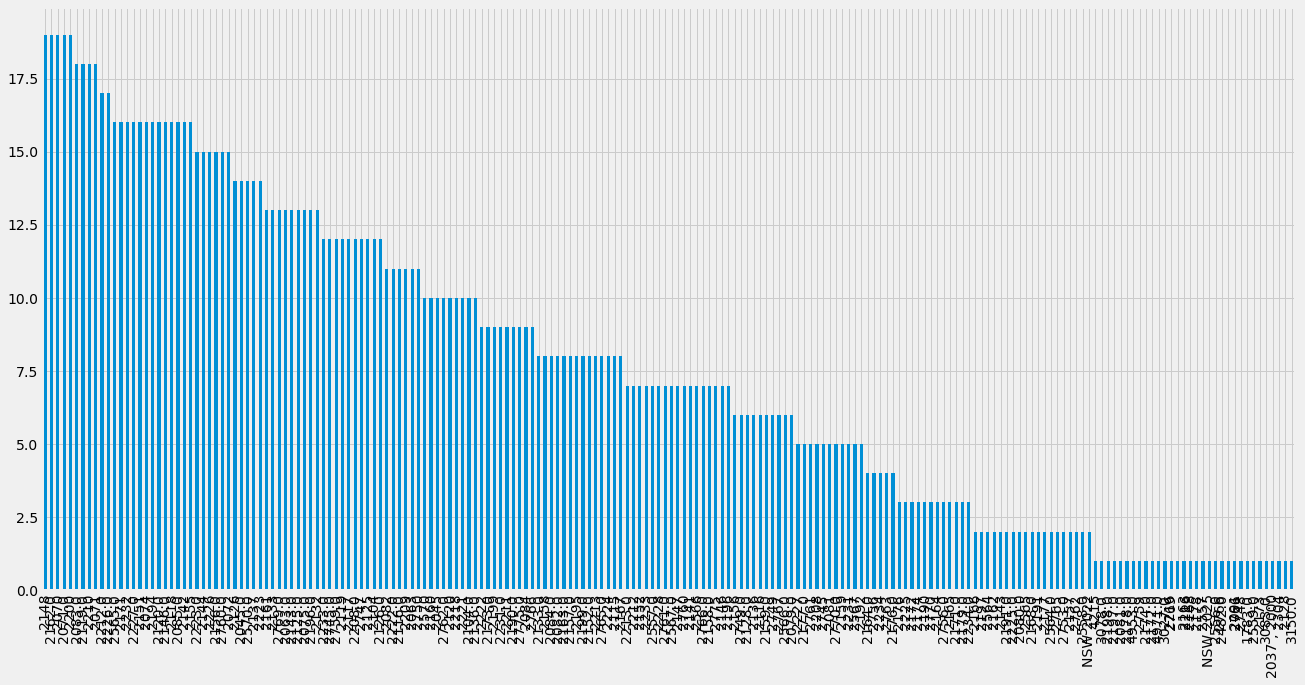

In [67]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 20].plot(kind="bar")

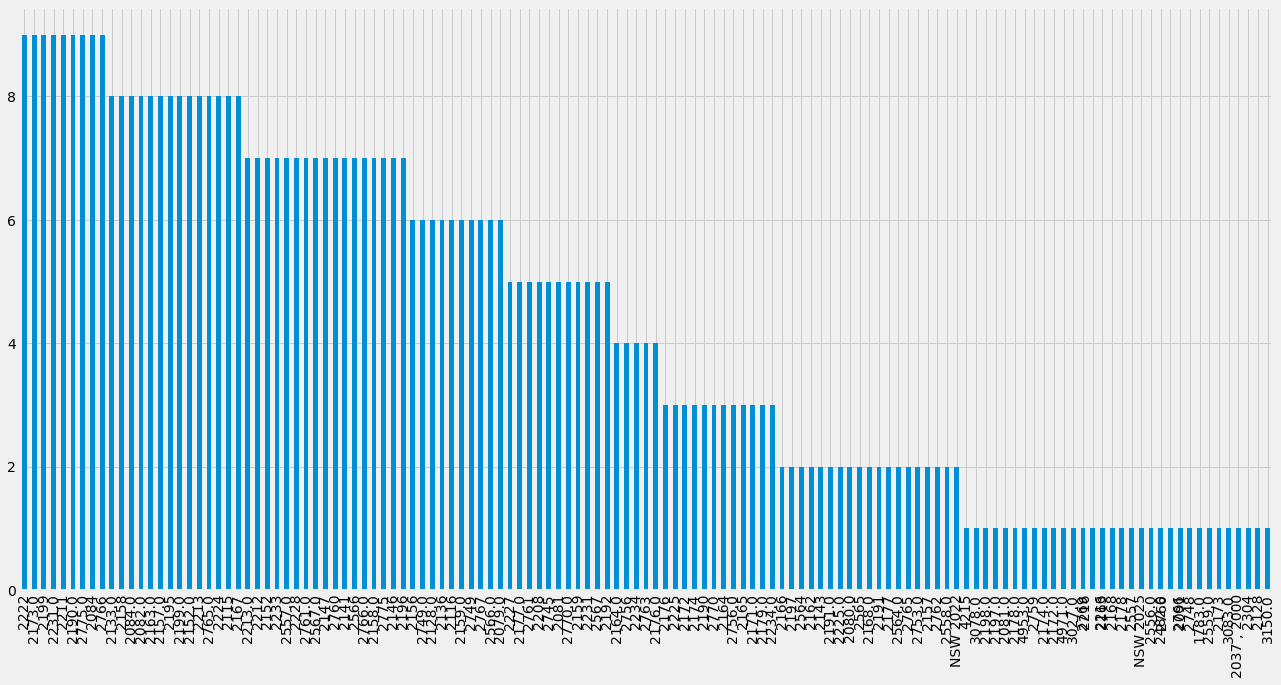

In [68]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 10].plot(kind="bar")

In [69]:
air_bnb.zipcode = air_bnb.zipcode.apply(remove)

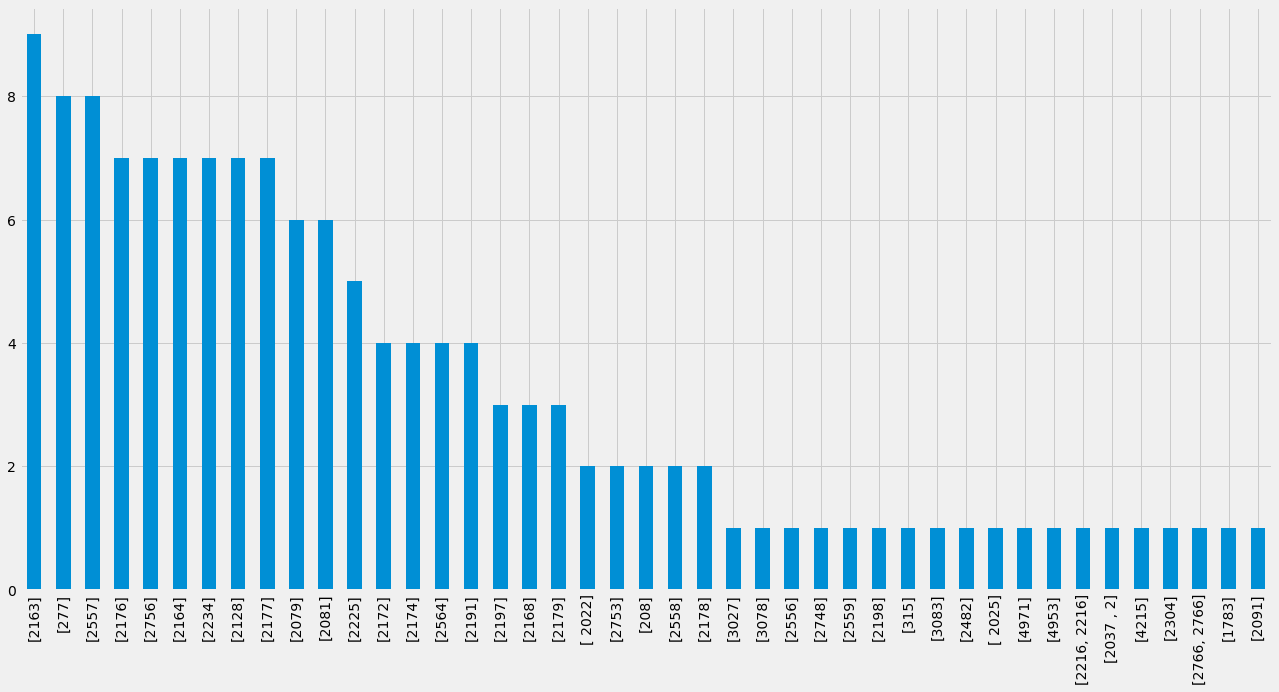

In [70]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 10].plot(kind="bar")

In [71]:
# # suburbs with least amount of airbnbs
# abz = air_bnb["zipcode"].value_counts()
# abz[abz > 10].plot(kind="bar")

In [72]:
air_bnb[air_bnb['zipcode']==1]['price'] 

Series([], Name: price, dtype: int64)

In [73]:
mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

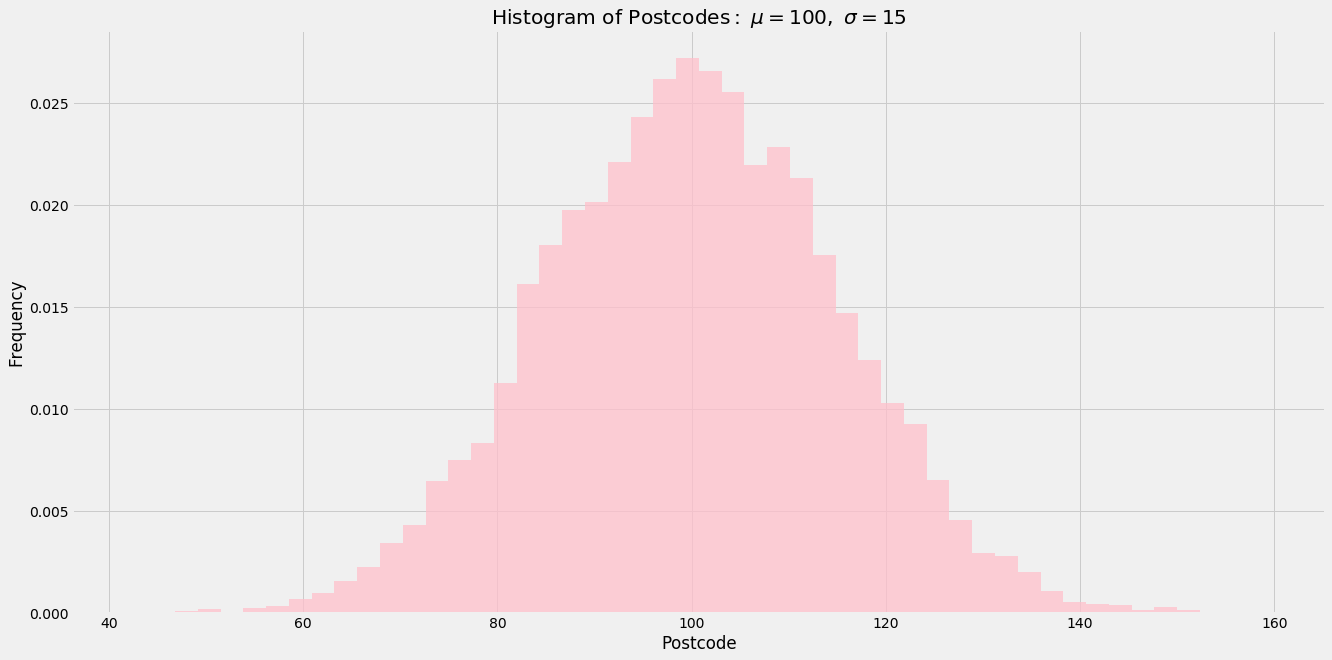

In [74]:
# the histogram of the data
plt.hist(x, 50, density=True, facecolor='pink', alpha=0.75)
plt.xlabel('Postcode')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ Postcodes:}\ \mu=100,\ \sigma=15$') # allows for latex formatting
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

## The amount of Airbnbs in NSW costing less than $200

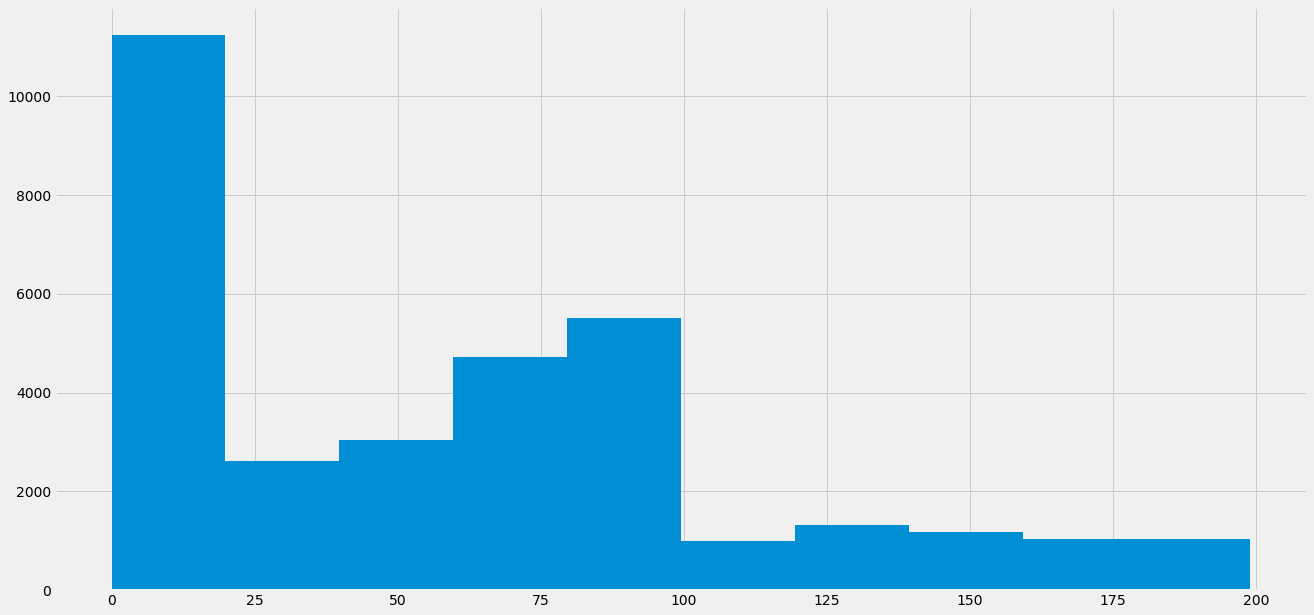

In [75]:
# amount of airbnbs with prices lower than $200
capped_price_data = air_bnb["price"][air_bnb["price"] < 200]

plt.hist(capped_price_data)
plt.show()

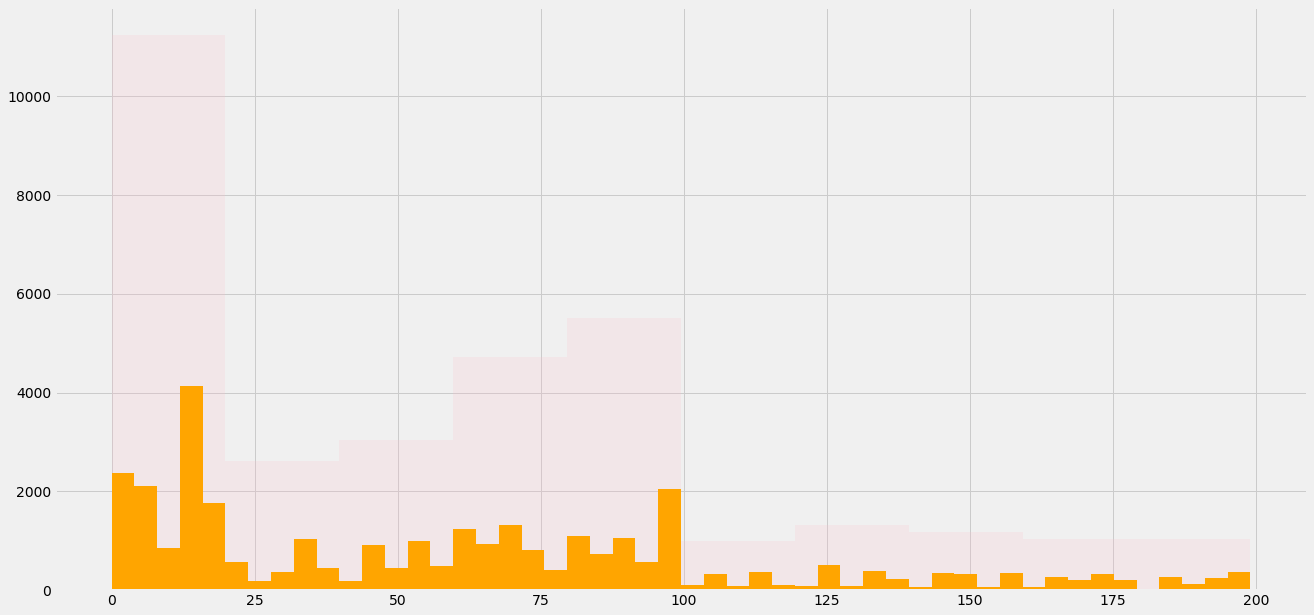

In [76]:
capped_price_data =air_bnb["price"][air_bnb["price"] < 200]

plt.hist(capped_price_data, bins=10, facecolor='pink', alpha=0.2) #<-old one
plt.hist(capped_price_data, bins=50, facecolor='orange', alpha=1)  #<-new one
plt.show()

## What's the average price of airbnbs in a suburb?

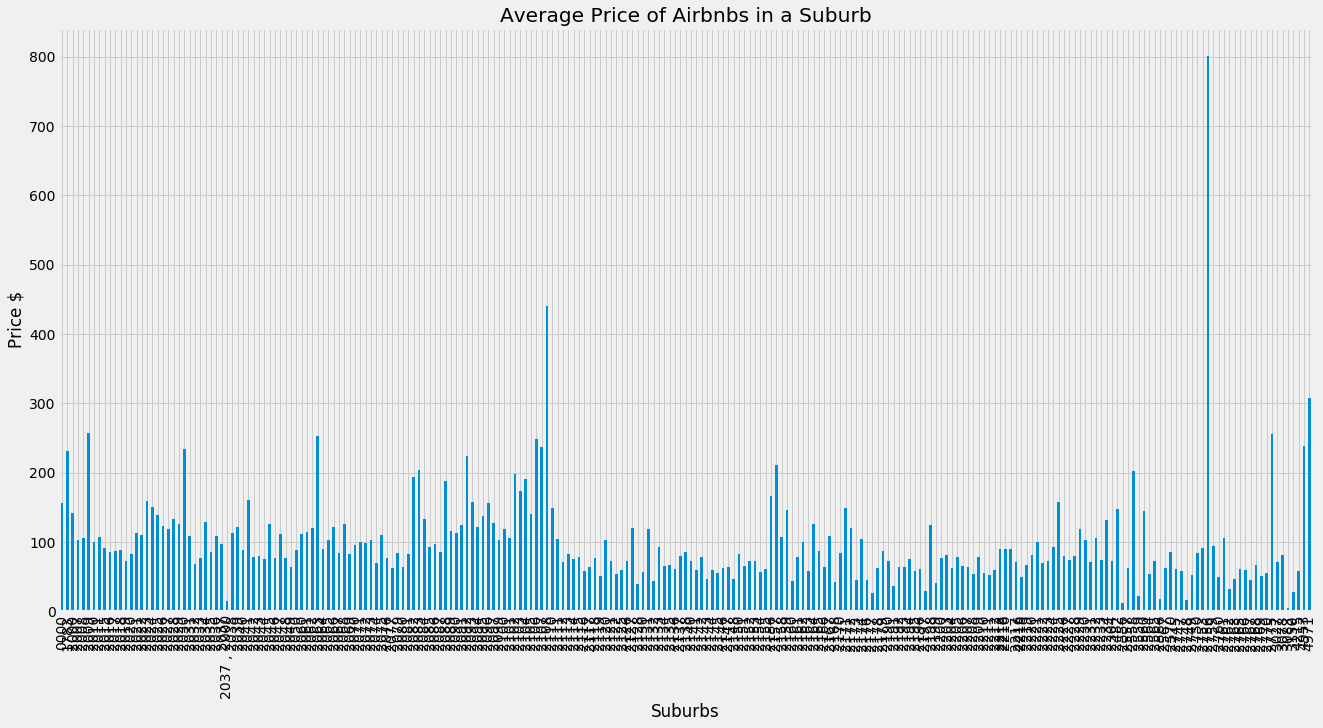

In [77]:
# the average price of airbnbs in suburb
average_price = air_bnb.groupby("simple_postcode").mean().price.plot(kind="bar")
# average price of suburbs
average_price.plot()
plt.title('Average Price of Airbnbs in a Suburb')
plt.ylabel('Price $')
plt.xlabel('Suburbs')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## Average number of people a house accomodates

Text(0.5, 0, 'ID')

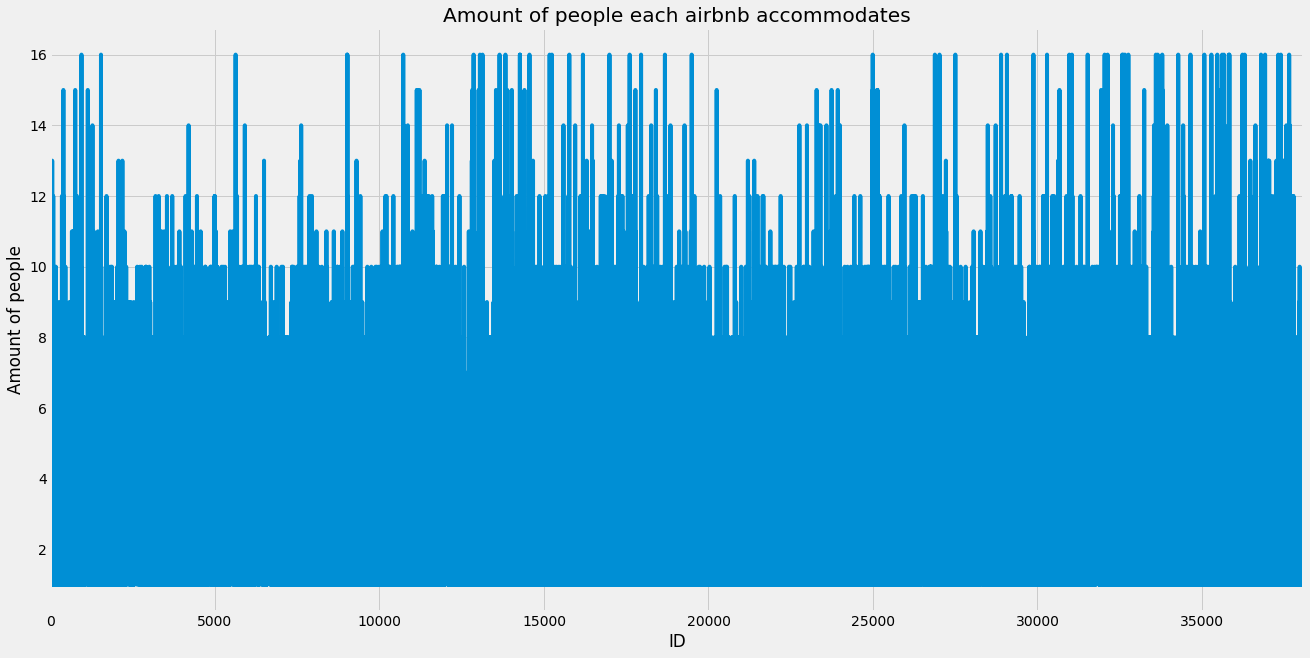

In [78]:
# how many people a house accommodates
air_bnb.accommodates.plot()
plt.title('Amount of people each airbnb accommodates')
plt.ylabel('Amount of people')
plt.xlabel('ID')

In [79]:
ac = air_bnb.accommodates.value_counts()
print(ac)

2     16204
4      7157
1      4098
6      3217
3      2377
5      1790
8      1452
7       691
10      471
9       285
12      120
16       62
11       61
14       39
13       29
15       27
Name: accommodates, dtype: int64


Text(0.5, 0, 'Postcode')

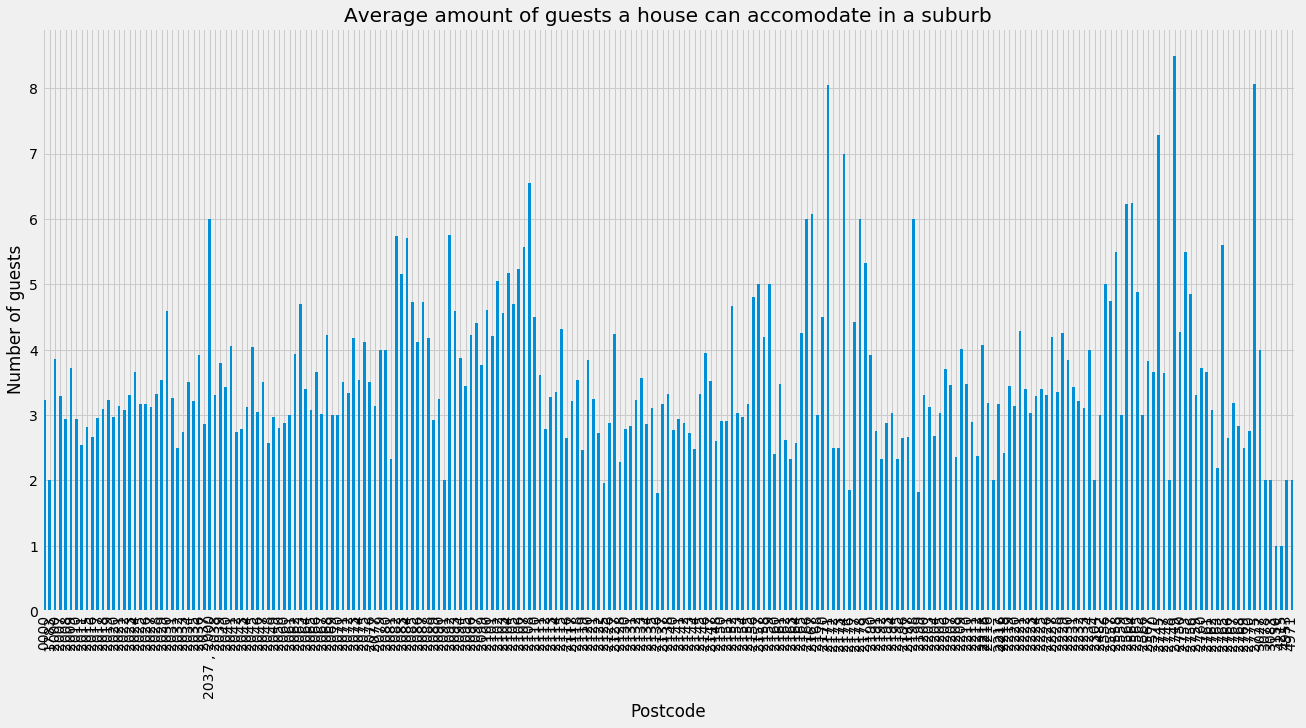

In [80]:
average_accomodates = air_bnb.groupby("simple_postcode").mean().accommodates.plot(kind="bar")
plt.title('Average amount of guests a house can accomodate in a suburb')
plt.ylabel('Number of guests')
plt.xlabel('Postcode')

### Grouping by postcodes

In [81]:
# groupby and aggregate 
# max or mean 
air_bnb_post = air_bnb.groupby(["simple_postcode"]).mean()

In [82]:
air_bnb_sum = air_bnb.groupby(["simple_postcode"]).sum()

In [83]:
air_bnb_sum.sample(5)

id         scrape_id  thumbnail_url  medium_url  \
simple_postcode                                                            
2097             3072012659  3028606505027550            0.0         0.0   
2221              825943900   706674851173095            0.0         0.0   
2759              335695274   262479230435721            0.0         0.0   
2032             8031214097  6723506441161161            0.0         0.0   
2045              489792906   484577040804408            0.0         0.0   

                 xl_picture_url      host_id  host_acceptance_rate  \
simple_postcode                                                      
2097                        0.0  10790533437                   0.0   
2221                        0.0   3395356994                   0.0   
2759                        0.0   1131308918                   0.0   
2032                        0.0  36503798622                   0.0   
2045                        0.0   1465507842                   0.0   

                 host_listings_count  host_total_listings_count  \
simple_postcode                                                   
2097                          1030.0                     1030.0   
2221                            71.0                       71.0   
2759                            71.0                       71.0   
2032                          1523.0                     1523.0   
2045                            30.0                       30.0   

                 neighbourhood_group_cleansed     latitude    longitude  \
simple_postcode                                                           
2097                                      0.0  -5059.79039  22694.31067   
2221                                      0.0  -1189.45732   5288.65428   
2759                                      0.0   -439.39762   1960.19506   
2032                                      0.0 -11296.50411  50359.23977   
2045                                      0.0   -813.13896   3627.38413   

                 accommodates  bathrooms  bedrooms   beds  square_feet  price  \
simple_postcode                                                                 
2097                      661      234.5     318.0  399.0          0.0  19190   
2221                      150       52.5      60.0   81.0          0.0   3475   
2759                       43       16.0      21.0   28.0          0.0   1214   
2032                      834      466.5     493.0  578.0          0.0  22538   
2045                       97       32.5      46.0   61.0          0.0   3012   

                 guests_included  minimum_nights  maximum_nights  \
simple_postcode                                                    
2097                         267             653           91965   
2221                          78              69           25252   
2759                          16              14           13507   
2032                         477            2049          219418   
2045                          39             186           17554   

                 minimum_minimum_nights  maximum_minimum_nights  \
simple_postcode                                                   
2097                                625                     665   
2221                                 69                      97   
2759                                 14                      17   
2032                               1786                    1992   
2045                                186                     200   

                 minimum_maximum_nights  maximum_maximum_nights  \
simple_postcode                                                   
2097                              91965                   91965   
2221                              25252                   25252   
2759                              13507                   13507   
2032                             219418                  219418   
2045                              17554                   17554   

                 min

## Comparison of top 3 suburbs with most airbnbs and top 3 suburbs with highest income

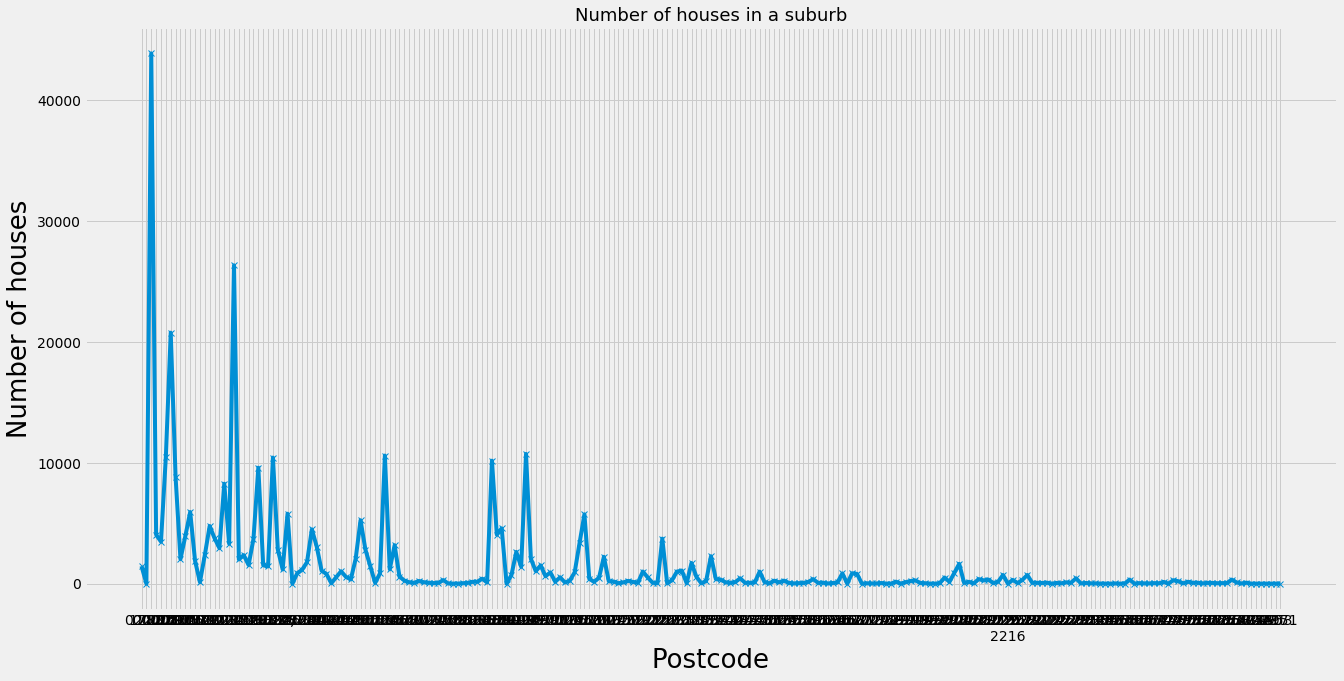

In [84]:
number_of_homes = air_bnb_sum["host_listings_count"]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Number of houses in a suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Number of houses', fontsize=26)
plt.grid(True)
plt.show()

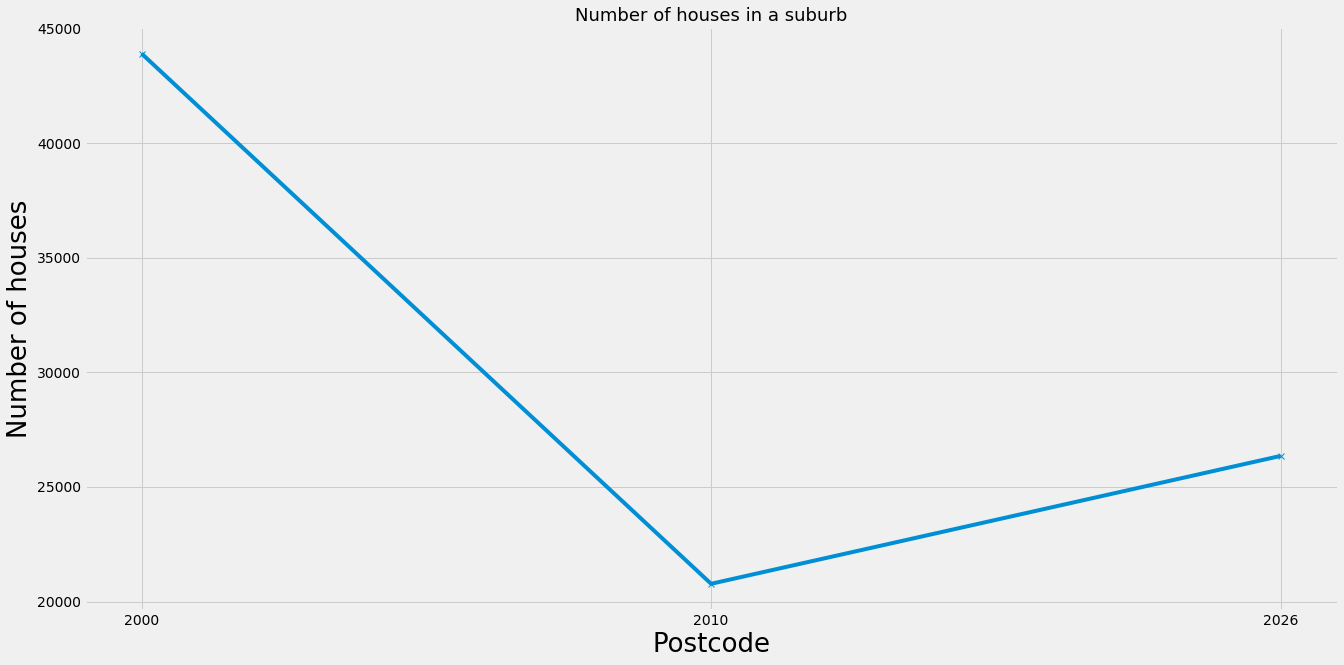

In [85]:
# shows the top 3 suburbs containing the most airbnbs
number_of_homes = air_bnb_sum.host_listings_count[air_bnb_sum.host_listings_count>int(20000)]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Number of houses in a suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Number of houses', fontsize=26)
plt.grid(True)
plt.show()

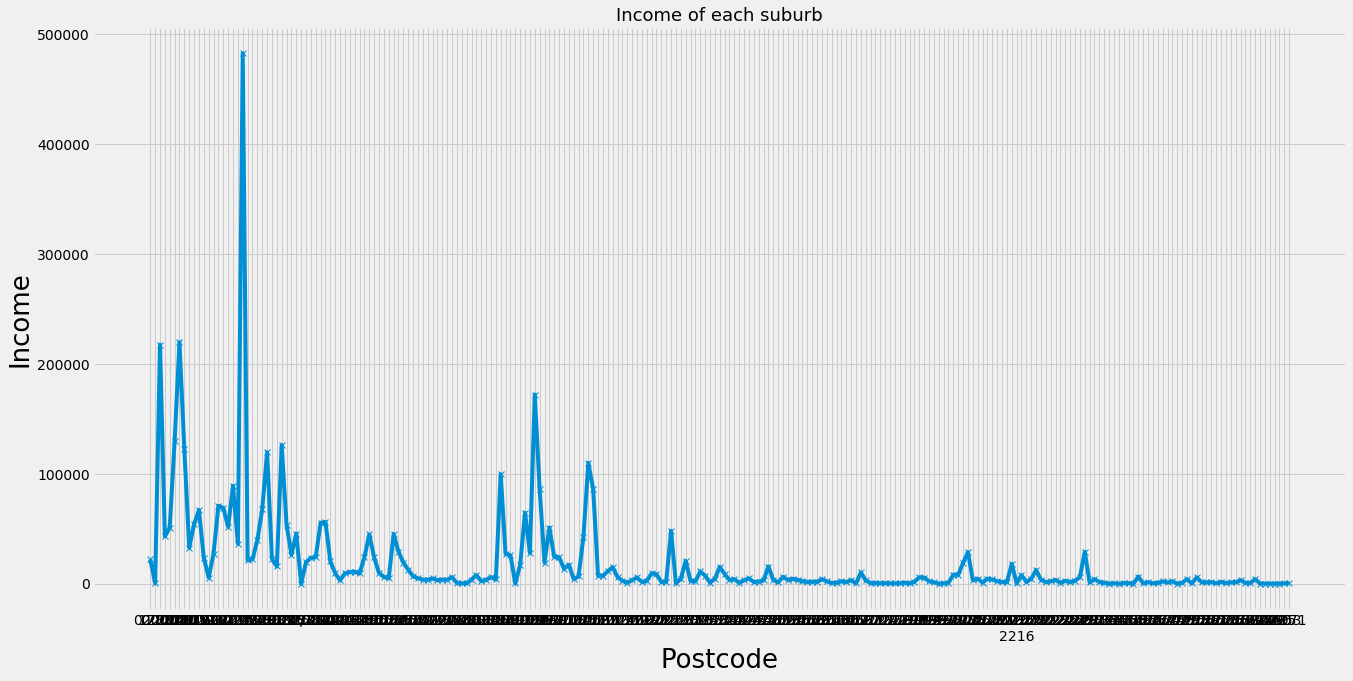

In [86]:
income = air_bnb_sum["price"]
# plt.xkcd()
plt.plot(income, "x-")
plt.title("Income of each suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Income', fontsize=26)
plt.grid(True)
plt.show()

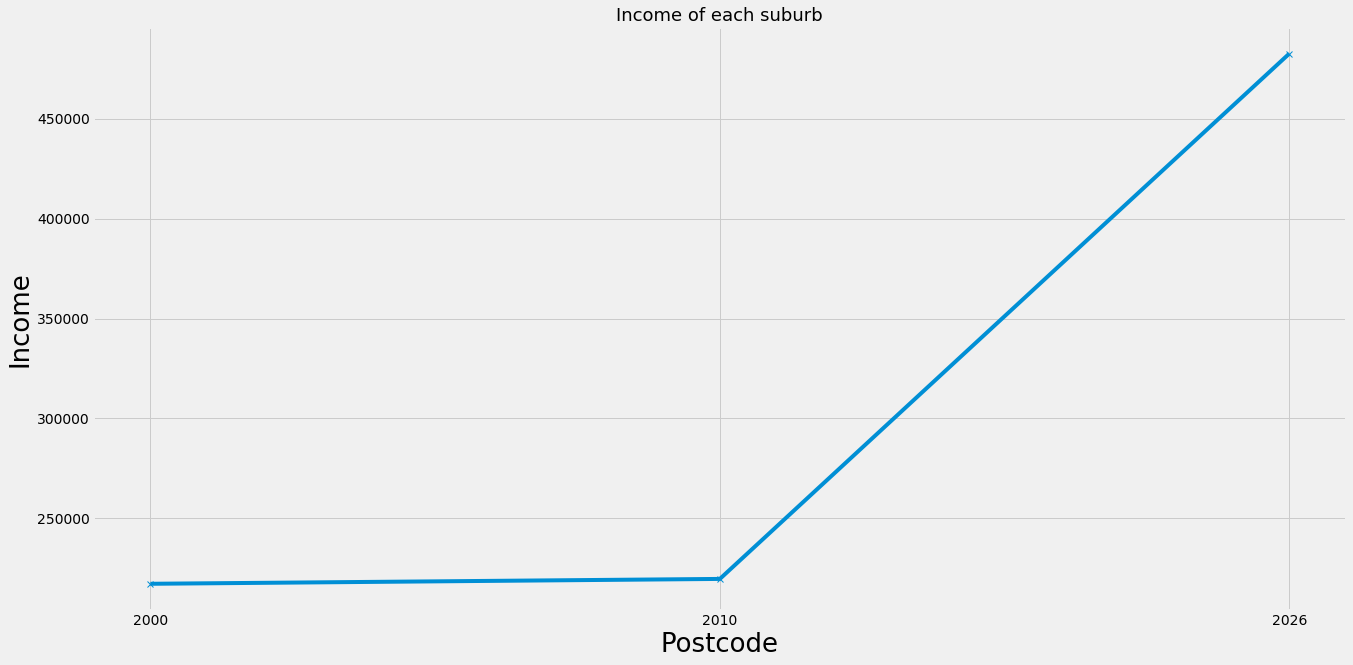

In [87]:
number_of_homes = air_bnb_sum.price[air_bnb_sum.price>int(200000)]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Income of each suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Income', fontsize=26)
plt.grid(True)
plt.show()

Postcode | Number of Houses in each suburb | Income
     --- | :---:                           | ---
2010     | 21000                           | $210000
2026     | 26000                           | $490000

## Are Airbnbs with Chinese characters in their description cheaper or more expensive?
> u'[\u4e00-\u9fff] searches for chinese and japanese characters in a string.

In [88]:
# Air_bnb's with chinese characters in their description 
import re
# def find_chinese(row):
#     for x in (row):
#         if re.search(u'[\u4e00-\u9fff]', str(x)):
#             return
#     return str(x)

# find_chinese(air_bnb.description)

In [89]:
def find_chinese(row):
    for x in (row):
        if re.search(u'[\u4e00-\u9fff]', str(x)):
#             print ('found chinese character in ' + str(x))
            return True
    return False

In [90]:
air_bnb["Chinese_char_in_row"] = air_bnb.apply(find_chinese,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
37204  36000068  https://www.airbnb.com/rooms/36000068  20190710033517   
8413   11777836  https://www.airbnb.com/rooms/11777836  20190710033517   
37402  36121474  https://www.airbnb.com/rooms/36121474  20190710033517   
2708    4778271   https://www.airbnb.com/rooms/4778271  20190710033517   
31924  31936135  https://www.airbnb.com/rooms/31936135  20190710033517   

      last_scraped                                            name  \
37204   2019-07-11                                    Shared house   
8413    2019-07-10               Room in adorable Sydney 2 bedroom   
37402   2019-07-11  Panoramic Urban Jewel | CBD Views w/ Balcony S   
2708    2019-07-10                     Beautiful beachside bedroom   
31924   2019-07-10      Deluxe Room with private shower and toilet   

                                                 summary  \
37204  Guildford town centre is 900meters from the ho...   
8413   Room is large with lots of storage space. 2 ba...   
37402  The place is close to Darling Harbour, ChinaTo...   
2708   Stunning,spacious, sunny quiet apartment with ...   
31924  The North Shore Hotel which is under new manag...   

                                                   space  \
37204                                                NaN   
8413   The space is in a beautiful building across fr...   
37402  This is a modern new apartment in a building t...   
2708   Palm trees outside entire building! Feels like...   
31924  Our Deluxe Room which is configured to accommo...   

                                             description experiences_offered  \
37204  Guildford town centre is 900meters from the ho...                none   
8413   Room is large with lots of storage space. 2 ba...                none   
37402  The place is close to Darling Harbour, ChinaTo...                none   
2708   Stunning,spacious, sunny quiet apartment with ...                none   
31924  The North Shore Hotel which is under new manag...                none   

                                   neighborhood_overview  \
37204                                                NaN   
8413   Glebe is the best neighborhood, just (Hidden b...   
37402  Located right next to Town Hall Train Station,...   
2708   Very quiet and happy! Bondi beach and rose bay...   
31924                                                NaN   

                                                   notes  \
37204                                                NaN   
8413   Glebe point road is just down the street and i...   
37402  We have a parking spot in another building nea...   
2708                                                 NaN   
31924                                                NaN   

                                                 transit  \
37204                                                NaN   
8413   There are multiple bus stops right by the hous...   
37402  The apartment is pretty central so if you are ...   
2708   Bus stop  is a 5 min walk also ferry is 10 min...   
31924                                                NaN   

                                                  access  \
37204                                                NaN   
8413   You'll be able to use all parts of the space e...   
37402                                                NaN   
2708                                                 NaN   
31924                                                NaN   

                                             interaction  \
37204                                                NaN   
8413   You're welcome to contact me with any question...   
37402  I won't be there to greet you as you will have...   
2708   I will be out of the Country however will have...   
31924  Reception office hours: •\tMonday - Friday: 6:...   

                                             house_rules  thumbnail_url  \
37204                                         10p.m-6a.m        

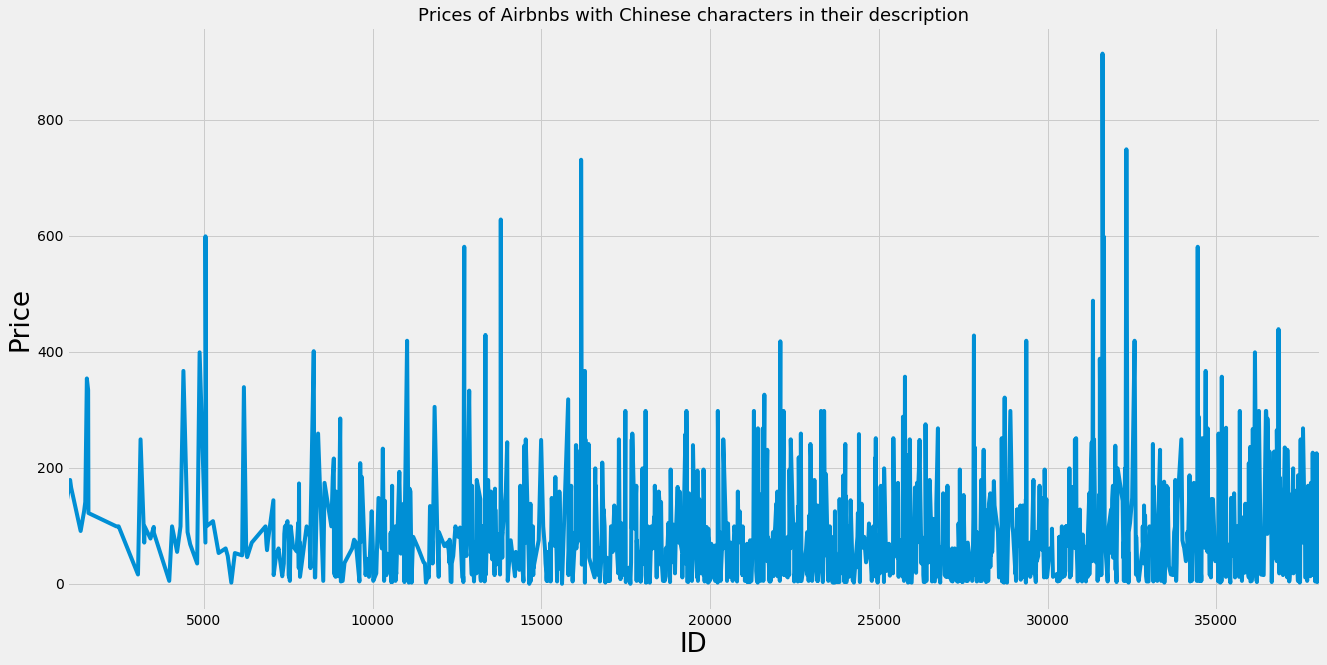

In [91]:
# summing up the prices for airbnbs with chinese description
# a file of all the airbnbs with chinese characters 
chairBNB = air_bnb[air_bnb["Chinese_char_in_row"]]
# plotting the price and ID of Air-bnbs
chairBNB.price.plot()
plt.title("Prices of Airbnbs with Chinese characters in their description", fontsize=18)
plt.xlabel('ID', fontsize=26)
plt.ylabel('Price', fontsize=26)
plt.grid(True)
plt.show()

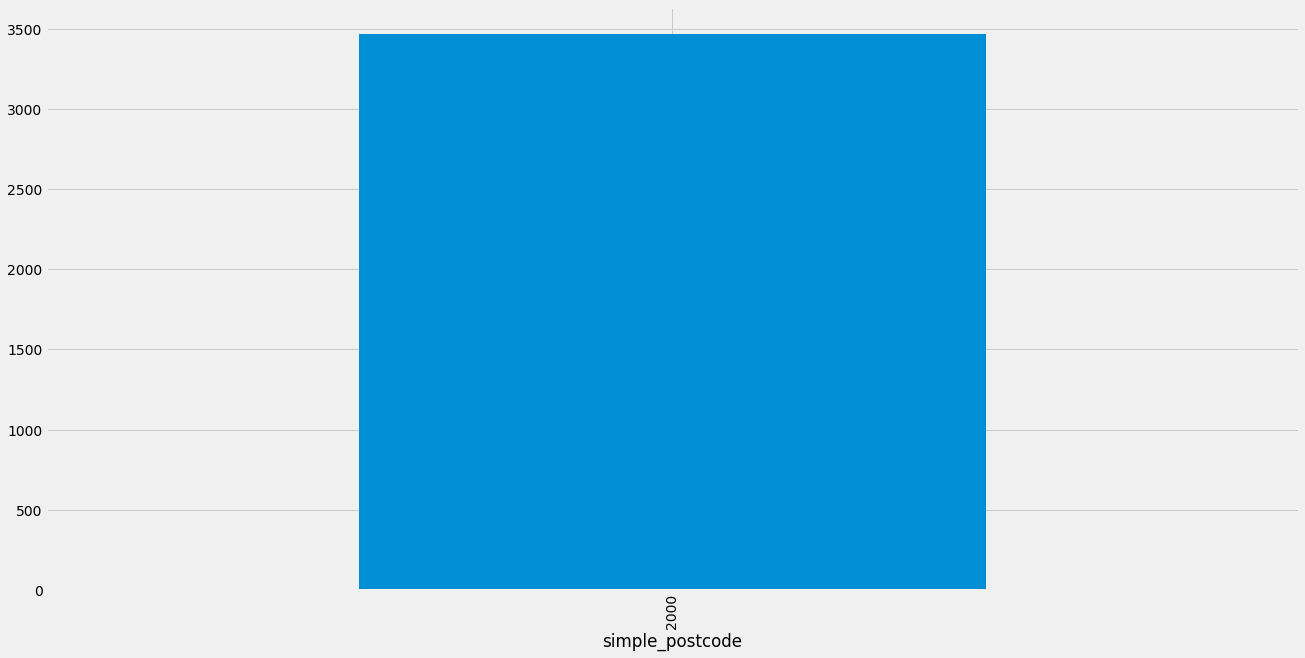

In [92]:
# Which suburb has the most houses with chinese descriptions?
chairBNBpost = chairBNB.groupby("simple_postcode")
cbs = chairBNBpost.host_listings_count.sum()
cbs[cbs>2000].plot(kind="bar")

In [93]:
# average price for airbnb with chinese characters in description 
chairBNB.price.mean()

85.62706043956044

In [94]:
# no chinese characters in description
def find_english(row):
    for x in (row):
        if re.search(u'[\u4e00-\u9fff]', str(x)):
#             print ('found chinese character in ' + str(x))
            return False
    return True

In [95]:
air_bnb["No_chinese_char_in_row"] = air_bnb.apply(find_english,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
30884  31046019  https://www.airbnb.com/rooms/31046019  20190710033517   
15842  19663142  https://www.airbnb.com/rooms/19663142  20190710033517   
16130  19920666  https://www.airbnb.com/rooms/19920666  20190710033517   
4983    8261751   https://www.airbnb.com/rooms/8261751  20190710033517   
15044  18841944  https://www.airbnb.com/rooms/18841944  20190710033517   

      last_scraped                                              name  \
30884   2019-07-10     Private Room with own bathroom in Surry Hills   
15842   2019-07-11  Close to Sydney’s Best Concert & Sports Stadium.   
16130   2019-07-10                         Large  room in woollahra!   
4983    2019-07-10                          Freshwater Family Escape   
15044   2019-07-10                       Andy and Lizzie's Beach Pad   

                                                 summary  \
30884  A bright and cosy bedroom that's large enough ...   
15842  This is a 3 bed apartment with a total North a...   
16130       Amazing room with private bathroom & balcony   
4983   Located in the suburb of Freshwater, our home ...   
15044  We have a beautifully renovated home available...   

                                                   space  \
30884  A beautiful 2 bedroom and 2 bathroom apartment...   
15842  Bright room close to bathroom.  Use of modern ...   
16130                           Quiet, bright anf moderm   
4983   Our home features 3 generous size bedrooms, ma...   
15044  Freshly modern, recently renovated 6 bedroom h...   

                                             description experiences_offered  \
30884  A bright and cosy bedroom that's large enough ...                none   
15842  This is a 3 bed apartment with a total North a...                none   
16130  Amazing room with private bathroom & balcony Q...                none   
4983   Located in the suburb of Freshwater, our home ...                none   
15044  We have a beautifully renovated home available...                none   

                                   neighborhood_overview  \
30884  The apartment has a great location as it is on...   
15842  Immediate neighbourhood is the Flemington mark...   
16130  very nice and quite with lots of pubs, caffes ...   
4983   Our home is located in a quiet leafy street an...   
15044  Really family friendly environment, that still...   

                                                   notes  \
30884                                                NaN   
15842                                                NaN   
16130                                         No shoes !   
4983                                                 NaN   
15044  We live here full time however we will have al...   

                                                 transit  \
30884                                                NaN   
15842          Train is the easiest, quickest & cheapest   
16130  189 bus to Bondi J 180/189 to CBD  1 minute wa...   
4983   We have ample on street parking available. If ...   
15044  You can bike, bus or drive to Manly or local b...   

                                                  access  \
30884  The complex has a pool, sauna and spa, and goo...   
15842                      Guest pool,Gym & Tennis court   
16130                                kitchen front door.   
4983   We invite guests to enjoy every aspect our pro...   
15044                                                NaN   

                                             interaction  \
30884                                                NaN   
15842  We are flexible - happy to chat or to respect ...   
16130                                                NaN   
4983   We will be away during your stay however we ha...   
15044       We are only a phone call, SMS or email away.   

                                             house_rules  thumbnail_url  \
30884                                               

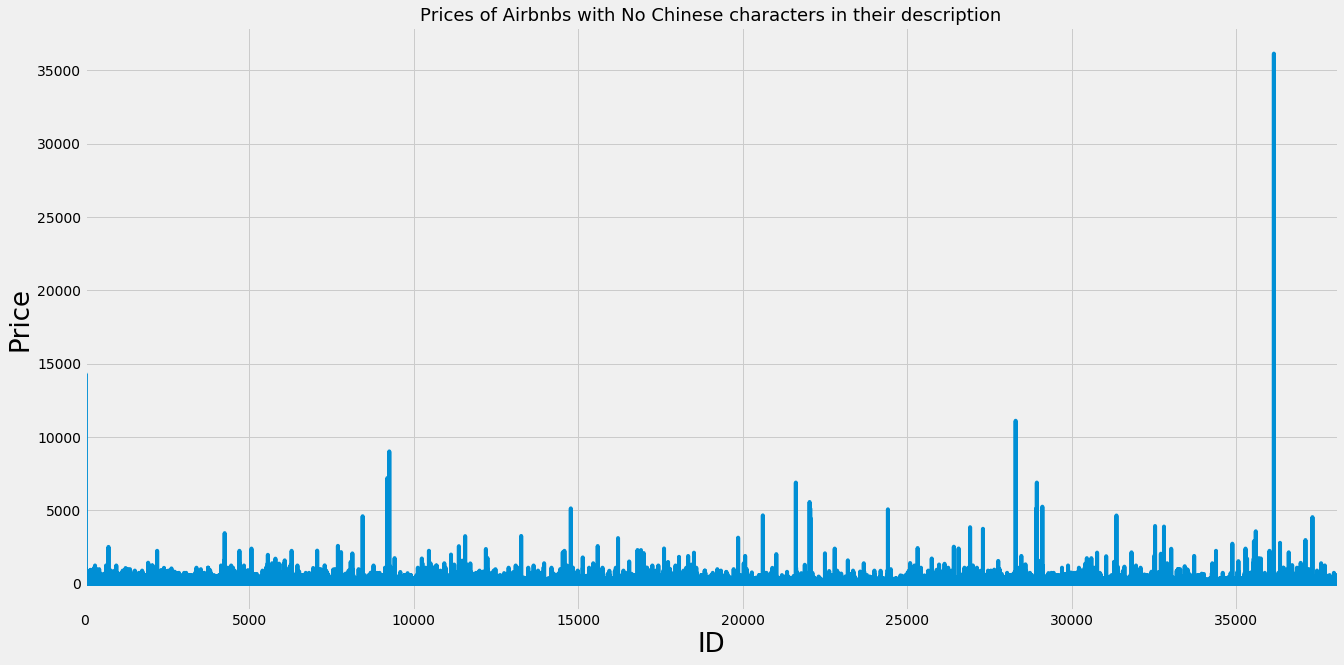

In [96]:
nochairBNB = air_bnb[air_bnb["No_chinese_char_in_row"]]
# plotting the price and ID of Air-bnbs
nochairBNB.price.plot()
plt.title("Prices of Airbnbs with No Chinese characters in their description", fontsize=18)
plt.xlabel('ID', fontsize=26)
plt.ylabel('Price', fontsize=26)
plt.grid(True)
plt.show()

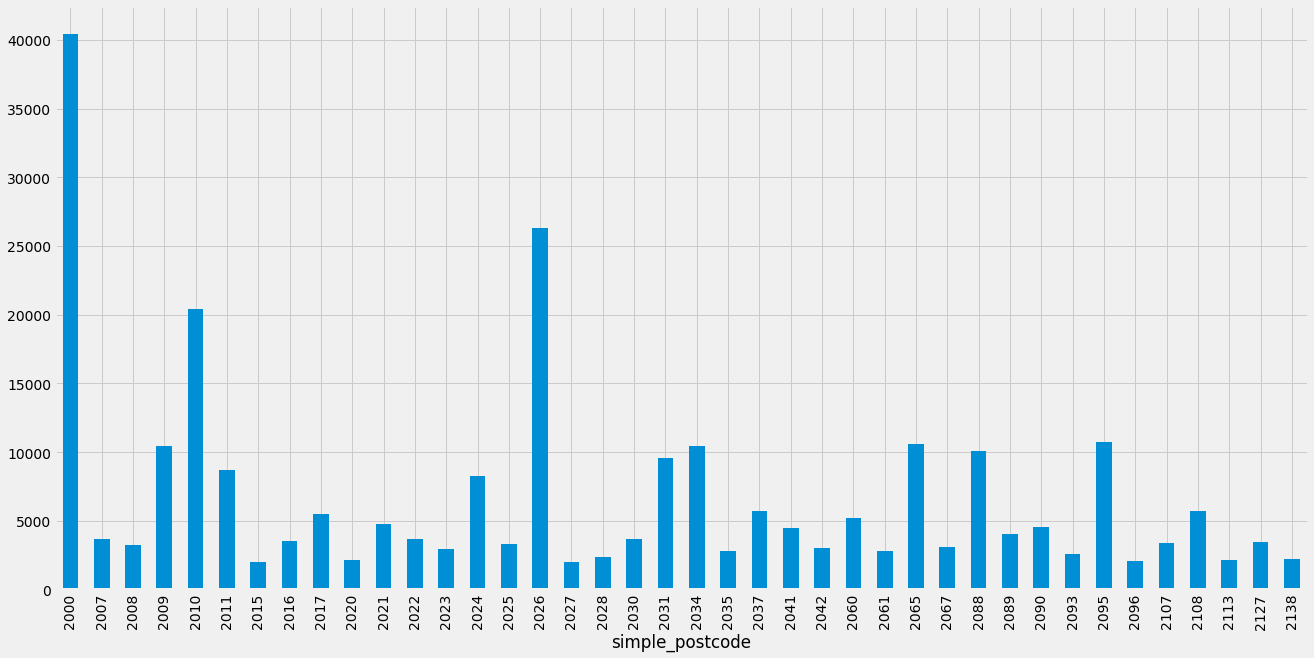

In [97]:
# Which suburb has the most houses with english descriptions?
nochairBNBpost = nochairBNB.groupby("simple_postcode")
ncbs = nochairBNBpost.host_listings_count.sum()
ncbs[ncbs>2000].plot(kind="bar")


# cbp = chairBNBpost.sum().host_listings_count>.plot(kind="bar")

In [98]:
nochairBNB.price.mean()

116.2879259501966

## Maping Data

In [99]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
air_bnb_burbs = burbs[burbs.NSW_LOCA_2 == ""]
air_bnb_burbs.head()
# air_bnb_burbs.plot()

Empty GeoDataFrame
Columns: [LC_PLY_PID, DT_CREATE, LOC_PID, NSW_LOCALI, NSW_LOCA_2, NSW_LOCA_5, NSW_LOCA_6, NSW_LOCA_7, geometry]
Index: []

In [100]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.columns
burbs.sample(2)

LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  NSW_LOCALI NSW_LOCA_1  \
3126      19089  2012-11-21      None  NSW3413  2012-02-04       None   
3721      26531  2016-09-12      None  NSW3633  2016-11-11       None   

            NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
3126       ROCKY CREEK       None       2371          G       None          1   
3721  SOUTH WEST ROCKS       None       None          G       None          1   

                                               geometry  
3126  POLYGON ((151.250291984 -29.2011763753, 151.25...  
3721  POLYGON ((153.0377802167 -30.88328729792, 153....

In [101]:
def clean_up_postcode_for_maps(row):
    k = row.LOC_PID
    if type(k) is str:
        if "NSW" in k:
            return k.strip('NSW')
        else:
            return k
    else:
        return k

burbs["LOC_PID"] = burbs.apply(clean_up_postcode_for_maps,axis=1)

In [102]:
# joining datasets together 
merged = burbs.set_index("LOC_PID").join(air_bnb_post)
merged.sample(4)

LC_PLY_PID   DT_CREATE DT_RETIRE  NSW_LOCALI NSW_LOCA_1   NSW_LOCA_2  \
4443      29852  2019-02-26      None  2018-02-08       None     WOOLWICH   
945       18457  2012-08-15      None  2012-10-30       None      CLIFTON   
2363      19141  2012-11-21      None  2012-02-04       None  LINDIFFERON   
859       24608  2015-05-22      None  2015-08-06       None  CASTLE COVE   

     NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
4443       None       None          G       None          1   
945        None       None          G       None          1   
2363       None       None          G       None          1   
859        None       None          G       None          1   

                                               geometry  id  scrape_id  \
4443  POLYGON ((151.17764579393 -33.83518332845, 151... NaN        NaN   
945   POLYGON ((150.973700167354 -34.2558357390862, ... NaN        NaN   
2363  POLYGON ((145.281386353 -35.3230030189, 145.28... NaN        NaN   
859   POLYGON ((151.20891329386 -33.77859793711, 151... NaN        NaN   

      thumbnail_url  medium_url  xl_picture_url  host_id  \
4443            NaN         NaN             NaN      NaN   
945             NaN         NaN             NaN      NaN   
2363            NaN         NaN             NaN      NaN   
859             NaN         NaN             NaN      NaN   

      host_acceptance_rate  host_listings_count  host_total_listings_count  \
4443                   NaN                  NaN                        NaN   
945                    NaN                  NaN                        NaN   
2363                   NaN                  NaN                        NaN   
859                    NaN                  NaN                        NaN   

      neighbourhood_group_cleansed  latitude  longitude  accommodates  \
4443                           NaN       NaN        NaN           NaN   
945                            NaN       NaN        NaN           NaN   
2363                           NaN       NaN        NaN           NaN   
859                            NaN       NaN        NaN           NaN   

      bathrooms  bedrooms  beds  square_feet  price  guests_included  \
4443        NaN       NaN   NaN          NaN    NaN              NaN   
945         NaN       NaN   NaN          NaN    NaN              NaN   
2363        NaN       NaN   NaN          NaN    NaN              NaN   
859         NaN       NaN   NaN          NaN    NaN              NaN   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
4443             NaN             NaN                     NaN   
945              NaN             NaN                     NaN   
2363             NaN             NaN                     NaN   
859              NaN             NaN                     NaN   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
4443                     NaN                     NaN                     NaN   
945                      NaN                     NaN                     NaN   
2363                     NaN                     NaN                     NaN   
859                      NaN                     NaN                     NaN   

      minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_30  \
4443                     NaN                     NaN              NaN   
945                      NaN                     NaN              NaN   
2363                     NaN                     NaN              NaN   
859                      NaN                     NaN              NaN   

      availability_60  availability_90  availability_365  number_of_reviews  \
4443              NaN              NaN               NaN                NaN   
945               NaN              NaN               NaN                NaN   
2363              NaN              NaN               NaN                NaN   
859               NaN              NaN               NaN                NaN   

      number_of_reviews_ltm  

## Which suburb has the largest accomodation?

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



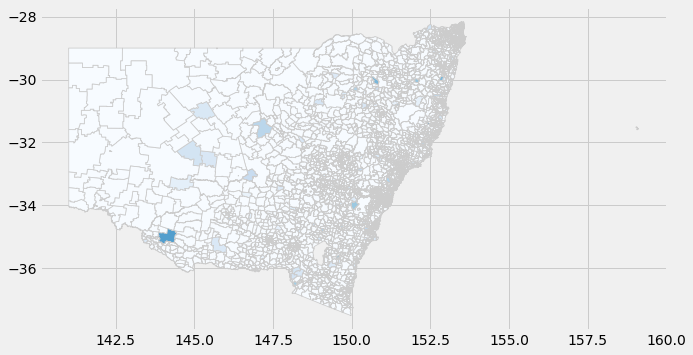

In [103]:
variable = "guests_included"
vmin, vmax = 0, 20
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

(140.0939567219233, 160.0107386088967, -37.9724793714895, -27.689617754120505)

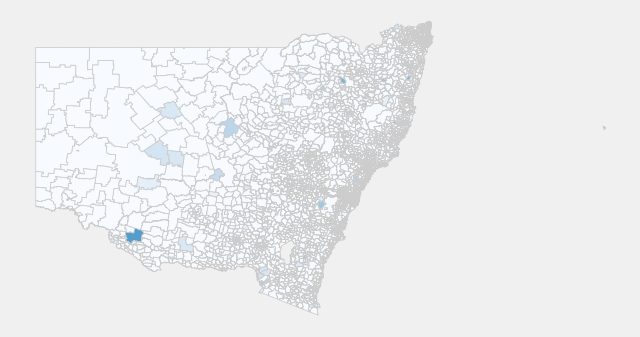

In [104]:
variable = "guests_included"
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")

Text(0.1, 0.08, 'Map of NSW')

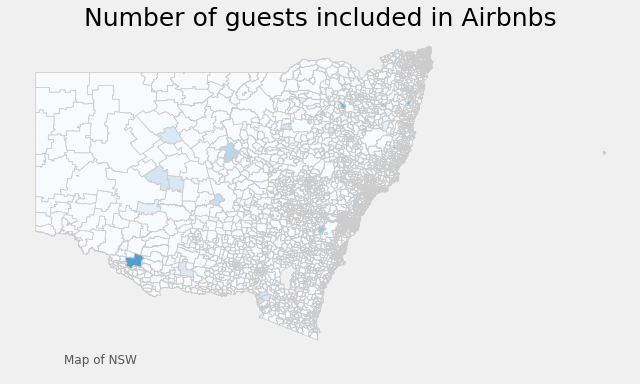

In [105]:
variable = "guests_included"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")
# add a title
ax.set_title("Number of guests included in Airbnbs", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Map of NSW", xy=(0.1, .08), xycoords="figure fraction", ha="left", va="top", fontsize=12, color="#555555")

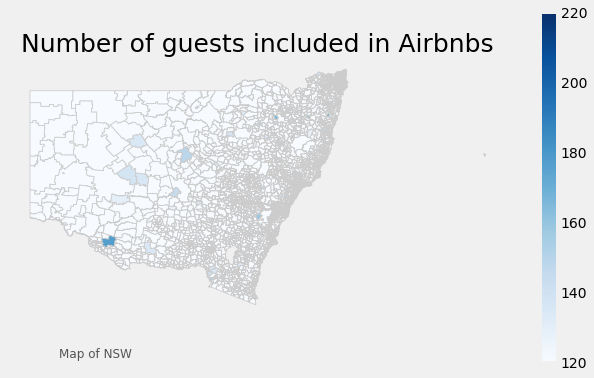

In [106]:
variable = "guests_included"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")
# add a title
ax.set_title("Number of guests included in Airbnbs", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Map of NSW", xy=(0.1, .08), xycoords="figure fraction", ha="left", va="top", fontsize=12, color="#555555")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [107]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

POINT (151.7246099649729 -32.88497041458911)


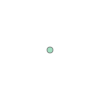

In [108]:
a = burbs.iloc[0]
print(a.centroid)
a.centroid

In [109]:
this_point = shapely.geometry.point.Point(144.3,-34.45)
burbs["distance_from_Maude"] = burbs.geometry.distance(this_point)

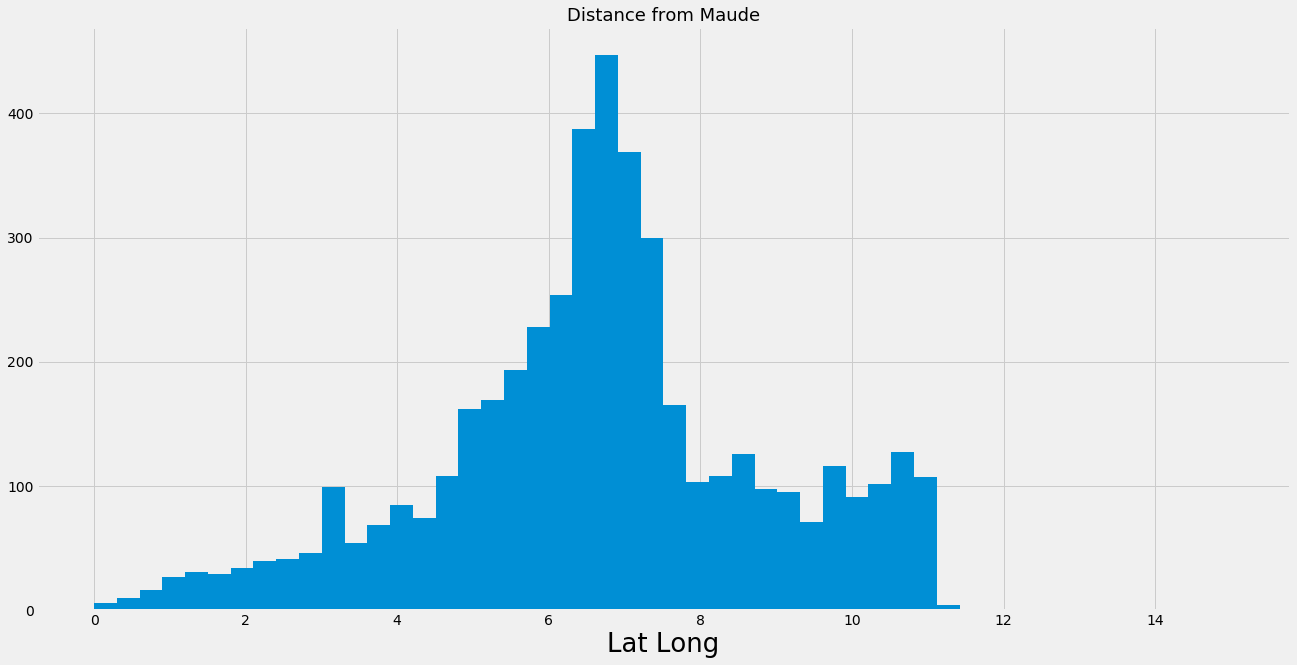

In [110]:
burbs.distance_from_Maude.hist(bins=50);
plt.title("Distance from Maude", fontsize=18)
plt.xlabel('Lat Long', fontsize=26)
plt.grid(True)
plt.show()

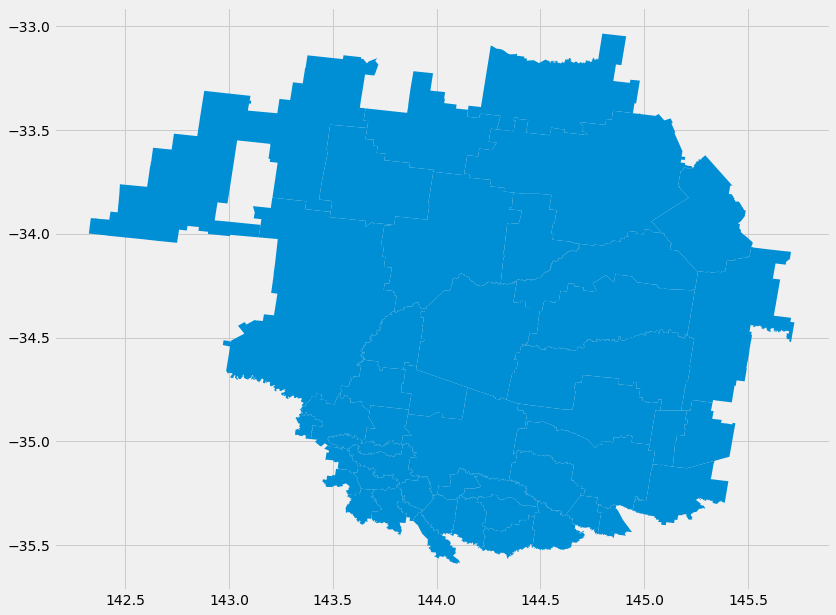

In [111]:
close_burbs = burbs[burbs.distance_from_Maude<1]
close_burbs.plot();

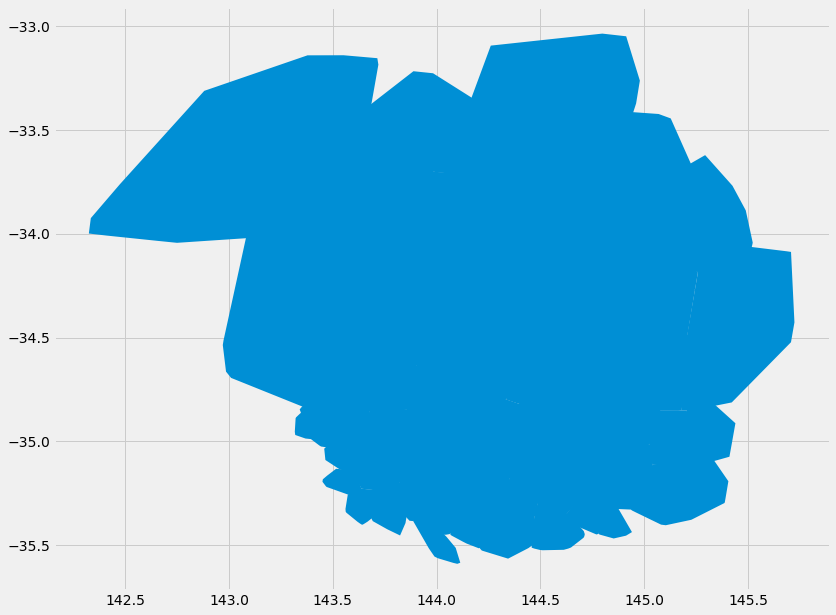

In [112]:
close_burbs.geometry.convex_hull.plot();

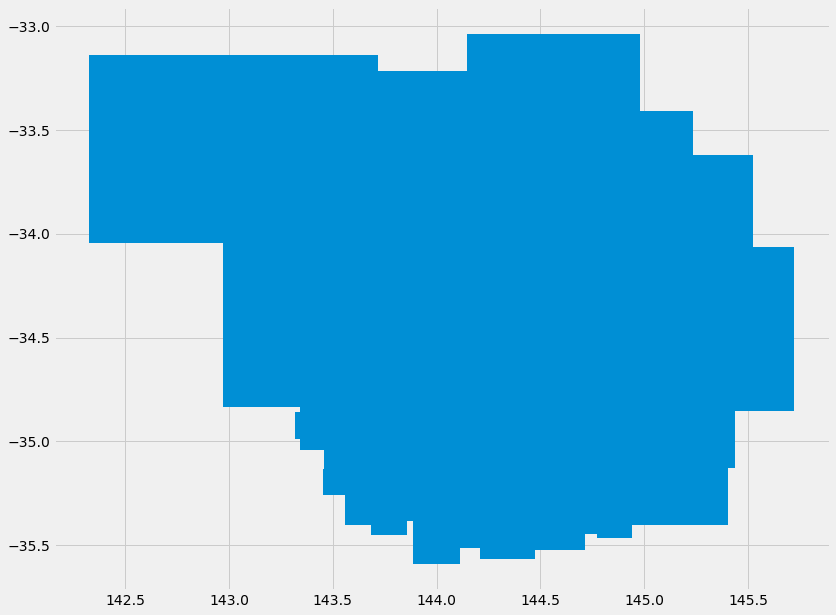

In [113]:
close_burbs.geometry.envelope.plot();

Text(0.5, 1, 'Suburbs near town with largest accomodation')

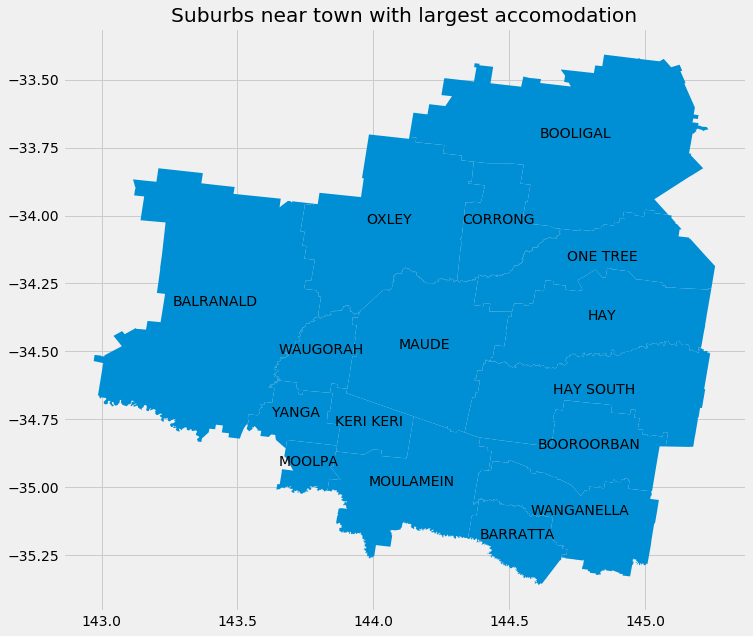

In [114]:
really_close_burbs = burbs[burbs.distance_from_Maude<0.6]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
    plt.annotate(row.NSW_LOCA_2, xy=tuple(row.centroid.coords)[0], ha='center')
plt.title('Suburbs near town with largest accomodation')

In [115]:
print(this_point)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if this_point.within(row.geometry):
        in_this_burb = row
        
in_this_burb

POINT (144.3 -34.45)


LC_PLY_PID                                                         17464
DT_CREATE                                                     2012-05-15
DT_RETIRE                                                           None
LOC_PID                                                             2546
NSW_LOCALI                                                    2012-07-27
NSW_LOCA_1                                                          None
NSW_LOCA_2                                                         MAUDE
NSW_LOCA_3                                                          None
NSW_LOCA_4                                                          None
NSW_LOCA_5                                                             G
NSW_LOCA_6                                                          None
NSW_LOCA_7                                                             1
geometry               POLYGON ((144.120085256053 -34.1924519579089, ...
centroid                    POINT (144.190039783909

In [116]:
in_this_burb = really_close_burbs[really_close_burbs.apply(lambda x: this_point.within(x.geometry) , axis=1)]
in_this_burb

LC_PLY_PID   DT_CREATE DT_RETIRE LOC_PID  NSW_LOCALI NSW_LOCA_1  \
559      17464  2012-05-15      None    2546  2012-07-27       None   

    NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
559      MAUDE       None       None          G       None          1   

                                              geometry  \
559  POLYGON ((144.120085256053 -34.1924519579089, ...   

                                         centroid  distance_from_Maude  
559  POINT (144.1900397839091 -34.48988714293753)                  0.0

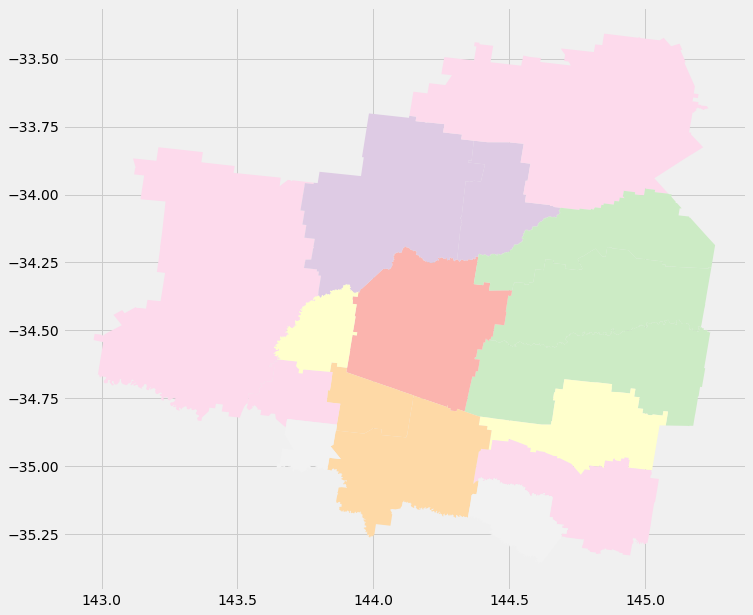

In [117]:
really_close_burbs.plot(column='distance_from_Maude', cmap='Pastel1');

# END OF PRESENTATION

> In conclusion, the Airbnb Dataset was an interesting dataset to analyse because of the diversity of information it provides. It informed me that it was cheaper to rent airbnbs with chinese characters in the description, go to Marrickville or Bondi for a Futon bed and much more. 

